<center>

# **<font size="7">Reinforcement Learning for Power Allocation in Multi-User Wireless Communication Systems</font>**
---

##  *Authors:*  
**Asma Boukhdhir**, **Aymen Daoud**, **Farouk Nasr**  

**Department of Computer and Software Engineering**  
**Polytechnique Montréal**  
**December 20, 2024**  

---  


## **Table of Contents**
1. [Introduction](#introduction)
2. [Environment setup](#setup)
3. [Deep Q-Network (DQN) implementation](#dqn)
4. [Double Deep Q-Network (DDQN) ](#ddqn)
5. [Rainbow DQN implementation](#rain)
6. [Proximal Policy Optimization (PPO) implementation](#ppo)


# **1. Introduction** <a name="introduction"></a>




In this notebook, we simulate a multi-user wireless communication network and  implement deep reinforcement learning algorithms for learning optimal power allocation strategies.

#### **Package Management and Import Setup**


## 1.1 - Package Installation

In [ ]:
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install tensorflow==2.8.0
!pip install stable-baselines3 pyglet
!pip install protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 36.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  A

## 1.2 - Importing Packages

In [ ]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"


import sys
import gym
import math
import time
import pylab
import cmath
import random
import itertools
import threading
import tensorflow
import scipy as sp
import numpy as np
import pandas as pd
from gym import Env
import scipy.io as sc
import tensorflow as tf
from sys import version
from absl import logging
from numpy import ndarray
from scipy import special
from gym.utils import seeding
from scipy.constants import *
from rl.agents import DQNAgent
from scipy.special import erfinv
from scipy.integrate import quad
from scipy.linalg import toeplitz
from numba import jit, njit, prange
from gym.spaces import Discrete, Box
from collections import deque, Counter
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from mpl_toolkits.mplot3d import Axes3D
from gym import Env, error, spaces, utils
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization

# Set of Times New Roman font
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

dtype = np.float32

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

/usr/local/lib/python3.10/dist-packages/tensorflow/core/framework/tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
/usr/local/lib/python3.10/dist-packages/tensorflow/core/framework/tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
/usr/local/lib/python3.10/dist-packages/tensorflow/core/framework/tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _TENSORSHAPEPROTO_DIM = _de

# **2 - M_MIMOEnv Environment Setup** <a name="setup"></a>

## 2.2 - Purpose of the `M_MIMOEnv` Environment

The goal of this environment is to provide a realistic simulation of a wireless communication network with multiple cells and user equipment (UEs). The environment:

- Models interactions between base stations (BSs) and UEs.
- Allows reinforcement learning algorithms to make power allocation decisions (actions) based on observed states.
- Provides a structured reward system to optimize network performance, like maximizing throughput and reducing interference.

## 2.3 - Overview of Key Steps and Components

This class is designed around the principles of reinforcement learning, where an agent (in this case, a power allocation model) interacts with an environment (the multi-cell MIMO system) and learns to optimize an objective (effective power allocation).

## 2.4 - Procedure and Functions Explained

### 2.4.1 - Initialization (`__init__`)

The initialization function sets up the environment by defining key parameters such as:

- **Network Layout**: Defined by the number of cells ($N$), transmission antennas ($M$), and UEs per cell ($K$).
- **Bandwidth and Noise Parameters**: These impact the achievable rates and interference.
- **Action and Observation Space**: The range of possible power levels the RL agent can choose from (`action_space`) and the metrics it will observe (`observation_space`).

**Purpose**: To create the fundamental setup of the environment, including generating initial channel matrices and setting observation-action boundaries.

### 2.4.2 - Channel and Precoding Setup

Key steps:

- **Channel Matrix (`self.H`)**: Generated by `get_channel_local_scatter`, models the physical layer with shadowing and fading effects.
- **Precoding (`self.precoding`)**: Uses zero-forcing (ZF) methods to reduce interference by shaping transmitted signals.

**Purpose**: This step sets up the physical layer components (like the channel matrix) necessary for calculating rates and interference.

### 2.4.3 - Action and Observation Spaces

The environment defines:

- **Actions** as discrete power levels, selected from a range (`min_p` to `max_p`), which the agent can allocate to each UE.
- **Observations** that include:
    - Transmission power level.
    - Signal-to-interference-plus-noise ratio (SINR).
    - Average downlink rate.

**Purpose**: These definitions give the RL agent a structured environment to interact with and learn from.

### 2.4.4 - Power Allocation Functions

This environment provides various power allocation functions, each of which represents a different way of distributing power to UEs.

- **`equal_PA`**: Allocates power equally among all users.
- **`random_PA`**: Assigns random power values within a specified range.
- **`maximum_PA`**: Assigns the maximum possible power to all users.
- **`maxprob_PA`**: Simplified max-product allocation approach for diversity in learning methods.

**Purpose**: These functions allow for baseline comparisons, enabling the model to understand and improve upon traditional allocation methods.

### 2.4.5 - Downlink Rate Calculation (`DL_rate`)

The `DL_rate` function calculates the achievable downlink rate for UEs based on:

- **Channel Matrix ($H$)**: Models the wireless channel’s behavior, influenced by distance, fading, and shadowing.
- **Precoding Matrix ($V$)**: Shapes transmitted signals to reduce interference.
- **Power Levels**: Determines how much power each BS allocates to UEs.

**Purpose**: To give a performance metric for each allocation choice, allowing the environment to give feedback to the agent in the form of rewards.

### 2.4.6 - Reward Mechanism and State Transition

- **Reward Calculation**: Based on the downlink rate, designed to guide the agent to optimize network performance (e.g., maximize throughput, minimize interference).
- **State Transition**: Each action updates the environment state, which includes the current power, SINR, and rate.

**Purpose**: This mechanism encourages the RL agent to take actions that maximize the downlink rate while observing realistic transitions in channel conditions.

### 2.4.7 Core RL Functions: `step` and `reset`

- **`step`**: Takes an action (power allocation decision), computes the resulting state and reward, and returns `done` if the episode ends.
    - **Inputs**: Power allocation decision from the RL agent.
    - **Outputs**: New state, reward, done flag, additional info.
  
- **`reset`**: Resets the environment to its initial state with new random configurations.
    - Resets the channel matrix and state variables to give the agent a fresh start for each episode.

**Purpose**: These functions create an interface for the RL agent to interact with the environment, allowing it to explore and learn an optimal power allocation policy.

# **Summary**

This environment provides a realistic simulation of power allocation in a multi-cell massive MIMO network, incorporating:

- **Physical Layer Modeling**: With detailed channel matrices, noise figures, and precoding.
- **Reward System**: Centered around downlink rates, encouraging the RL agent to optimize power allocations.
- **Comparison Benchmarks**: Various allocation functions (equal, random, maximum) for baseline performance comparisons.

The purpose of this environment is to support reinforcement learning studies by simulating realistic, complex MIMO network conditions and providing a space where RL agents can learn to optimize power allocation in wireless communication systems.


In [ ]:
class M_MIMOEnv(Env):
  def __init__(self, N, M, K):
##########################################################################################################################################################################################################################################
# start : multi-cell massive MIMO envrionment

    self.N = N              # number of cells is equals to number of BSs
    self.M = M              # number of BS transmission antennas
    self.K = K              # number of UEs in a cell
    self.BW = 10e6          # Bandwidth = 10MHz
    self.NF = 7             # Power of noise figure [dBm]
    self.Ns = 10            # Number of sample
    self.min_p = -20        # Minimum transmission power [dBm]
    self.max_p = 23         # Maximum transmission power [dBm]
    self.num_p = 10         # Number of possible actions

    # get multi-cell massive MIMO channel matrix (slow generating w/ shadowing, fading)
    self.H, self.H_gain = self.get_channel_local_scatter(no_realization = self.Ns)

    # get ZF precoding vector without antenna selection
    self.precoding = self.antenna_selection(self.H, ant_sel = False)

    # get random seed
    self.seed()

    # initialize step counter
    self.count = 0

    # initialize state
    self.state = None
    self.downlink_rate = None
    self.rate_list = []

    self.action_values = self.get_power_set()
    self.num_actions = len(self.action_values)
    self.action_space = spaces.Discrete(self.num_actions)
    self.action_length = self.num_actions

    # observation consists of the transmission power, SINR, and average sum-rate
    lower_bound = np.array([self.min_p, -(np.finfo(np.float32).max), -(np.finfo(np.float32).max)], dtype=np.float32)
    higher_bound = np.array([self.max_p, np.finfo(np.float32).max, np.finfo(np.float32).max], dtype=np.float32)

    self.observation_space = spaces.Box(lower_bound, higher_bound, dtype = np.float32)



##########################################################################################################################################################################################################################################
# start : multi-cell massive MIMO downlink scenario

  # generate dBm
  def get_power_set(self):
    power_set = np.hstack([np.zeros((1), dtype=dtype), 1e-3*pow(10., np.linspace(self.min_p, self.max_p, self.num_p-1)/10.)])
    return power_set

  # generate random seed
  def randn2(self, *args, **kargs):
    args_r = tuple(reversed(args))
    uniform = np.random.rand(*args_r)
    untiform = uniform.transpose()

    return np.sqrt(2) * erfinv(2 * uniform - 1)

  # generate hermitian matrix
  def hermitian(self, X):
    return X.conj().swapaxes(-1, -2)
  # Divide function by using hermitian.
  def mldivide(self, A: ndarray, B: ndarray, A_is_hermitian=False):
    if A_is_hermitian:
        return self.hermitian(np.linalg.solve(A, self.hermitian(B)))
    else:
        return self.hermitian(np.linalg.solve(self.hermitian(A), self.hermitian(B)))


  # correlation in term of real. signal parts.
  @njit
  def correlation_real(self, x, antenna_spacing, col):
    return np.cos(2 * np.pi * antenna_spacing * col * np.sin(x))


  # correlation in term of imag. signal parts.
  @njit
  def correlation_imag(self, x, antenna_spacing, col):
    return np.sin(2 * np.pi * antenna_spacing * col * np.sin(x))


  # probability density function (PDF) : gussian
  @njit
  def gaussian_pdf(self, x, mean, dev):
    return np.exp(-(x-mean) ** 2 / (2 * dev ** 2)) / (np.sqrt(2 * np.pi) * dev)


  # correlation function
  @njit
  def corr(self, x, theta, asd, antenna_spacing, dist, col, real_imag):
    if real_imag == 0:
        res = np.cos(2 * np.pi * antenna_spacing * col * np.sin(x))
    else:
        res = np.sin(2 * np.pi * antenna_spacing * col * np.sin(x))
    if dist =='gaussian':
        res *= self.gaussian_pdf(x, theta, asd)
    return res


  # Convert dBm to watts
  def dBm2Watts(self, P):
    # 1e-3* pow(10., self.n_power/10.)
    # P[w] = 10 ^ ((P[dBm] - 30) / 10);
    # P_watts = 1e-3 * pow(10., P/10.)
    P_watts = (10 ** ((P - 30) / 10))
    return P_watts


  # local scattering channel model. where the local is a single cell in total cell
  def R_local_scattering(self, M, theta, asd_deg, antenna_spacing=0.5, dist='Gaussian', accuracy=1, dtype=np.complex128):

    # In radians
    asd = asd_deg * np.pi / 180

    # correlation matrix is Toeplitz structure, so only need first row
    first_row = np.zeros([M,], dtype=dtype)

    if accuracy == 1:
        lb = None
        ub = None

        dist = dist.lower()
        if dist == 'gaussian':
            lb = theta - 20 * asd
            ub = theta + 20 * asd

        else:
            raise NotImplementedError

        for col in range(0, M):
            # distance from the first antenna
            c_real:float = quad(func=self.corr, a=lb, b=ub, args=(theta, asd, antenna_spacing, dist, col, 0))[0]
            c_imag:float = quad( func=self.corr, a=lb, b=ub, args=(theta, asd, antenna_spacing, dist, col, 1))[0]

            first_row[col] = complex(c_real, c_imag)
    elif accuracy == 2:
        # Gaussian distribution
        distance = np.arange(M)
        x1 = np.exp(1j * 2 * np.pi * antenna_spacing * np.sin(theta) * distance)
        x2 = np.exp(-asd ** 2 / 2 * (2 * np.pi * antenna_spacing * np.cos(theta) * distance) ** 2)
        first_row = x1 * x2

    return toeplitz(c=first_row.conjugate())


  # Channel statistics between UE's at random locations and the BS.
  def channel_stat_setup(self, N, K, M, asd_degs, no_BS_per_dim=None, accuracy=2,):
    # square side, in meters
    side_length = 500

    # pathloss exp
    alpha = 3.76

    # avg. channel gain in dB at the ref. distance 1 meter. At exponent set to 3.76, at 1km it's -148.1 dB
    constant_term = -35.3

     # standard deviation of shadow fading
    sigma_sf = 10

    # minimum distance between BS and UEs
    min_UE_BS_dist = 25

    # maximum distance between BS and UEs
    max_UE_BS_dist = 300

    # antenna spacing # of wavelengths
    antenna_spacing = 0.5
    if no_BS_per_dim is None:
        no_BS_per_dim = np.array([np.sqrt(N), np.sqrt(N)])
    inter_bs_distance = side_length / no_BS_per_dim

    # scatter the BSs
    BS_positions = np.stack(np.meshgrid(np.arange(inter_bs_distance[0]/2, side_length, inter_bs_distance[0]),np.arange(inter_bs_distance[1]/2, side_length, inter_bs_distance[1]),indexing='ij'),axis=2).reshape([-1,2])

    # now all the other nine alternatives of the BS locations
    wrap_locations = np.stack(np.meshgrid(np.array([-side_length, 0, side_length]), np.array([-side_length, 0, side_length]), indexing='ij' ), axis=2).reshape([-1,2])

    # for each BS locations, there are 9 possible alternative locations including the original one. Here uses broadcasting to add (9,2) to a (num_BS, 1, 2) to get a (num_BS, 9, 2)
    BS_positions_wrapped = np.expand_dims(BS_positions, axis=1) + wrap_locations

    UEpositions = np.zeros([K, N, 2])
    perBS = np.zeros([N,], dtype=np.int32)

    # normalized spatial correlation matrices
    R = np.zeros([M, M, K, N, N, len(asd_degs)], dtype=np.complex128)

    self.channel_gain = np.zeros([K, N, N])

    for i in range(N):
        # put K UEs in the cell, uniformly. UE's not satisfying the minimum distance are replaced
        res = []
        while perBS[i] < K:
            UEremaining = K - perBS[i]
            pos = np.random.uniform(-inter_bs_distance/2, inter_bs_distance/2,size=(UEremaining, 2))
            cond = np.linalg.norm(pos, ord=2, axis=1) >= min_UE_BS_dist

            # satisfying minimum distance with respect to BS shape
            pos = pos[cond, :]
            for x in pos:
                res.append(x + BS_positions[i])
            perBS[i] += pos.shape[0]
        UEpositions[:, i, :] = np.array(res)

        # loop through all BS for cross-channels
        for j in range(N):
            # distance between all UEs in cell i to BS j, considering wrap-around.
            dist_ue_i_j = np.linalg.norm(np.expand_dims(UEpositions[:, i], axis=1) - BS_positions_wrapped[j, :, :], axis=2)
            dist_bs_j = np.min(dist_ue_i_j, axis=1)
            which_pos = np.argmin(dist_ue_i_j, axis=1)

            # average channel gain with large-scale fading mdoel in (2.3), neglecting shadow fading
            self.channel_gain[:, i, j] = constant_term - alpha * 10 * np.log10(dist_bs_j)

            # generate spatial correlation matrices for channels with local scattering model
            for k in range(K):
                vec_ue_bs = UEpositions[k, i] - BS_positions_wrapped[j, which_pos[k]]
                angle_BS_j = np.arctan2(vec_ue_bs[1], vec_ue_bs[0])
                for spr, asd_deg in enumerate(asd_degs):
                    R[:, :, k, i, j, spr] = self.R_local_scattering( M, angle_BS_j, asd_deg, antenna_spacing, accuracy=accuracy)

        # all UEs in cell i to generate shadow fading realizations
        for k in range(K):
            # see if another BS has a larger avg. channel gain to the UE than BS i
            while True:
                # generate new shadow fading realizations until all UE's in cell i has its largest avg. channel gain from BS i
                shadowing = sigma_sf * self.randn2(N)
                channel_gain_shadowing = self.channel_gain[k, i] + shadowing
                if channel_gain_shadowing[i] >= np.max(channel_gain_shadowing):
                    break
            self.channel_gain[k,i,:] = channel_gain_shadowing

    return R, self.channel_gain


  # Normalized the complex values.
  def complex_normalize(self, X, axis=-1):
    mags = np.linalg.norm(np.abs(X), axis=axis, keepdims=True)
    return X / mags


  # Generate noise figure with bandwidth (20MHz)
  def noise_dbm(self,):
    return -174 + 10 * np.log10(self.BW) + self.NF


  # generate the ZF precoded combination
  def zf_combining(self,H):
    H1 = H
    A = self.hermitian(H1) @ H1 + 1e-12 * np.eye(H1.shape[-1])
    B = H1
    res = self.mldivide(A, B, A_is_hermitian=True)
    return res


  # Generate uncorrelated Rayleigh fading channel realizations with unit variance
  def get_H_rayleigh_unit(self, M, K, N, Ns):
    randn2 = np.random.randn
    H = randn2(N, N, K, M, Ns) + 1j * randn2(N, N, K, M, Ns)
    return np.sqrt(0.5) * H


  # Get local scattering channel matrix
  def get_channel_local_scatter(self, no_realization):
    # return shape:  Ns x N x N x K x M
    if self.N > 1 and self.N < 4:
        no_BS_per_dim = np.array([1, self.N])
    else:
        no_BS_per_dim = None
    R, gain_db = self.channel_stat_setup(self.N, self.K, self.M,no_BS_per_dim=no_BS_per_dim,asd_degs=[30,], accuracy=2)
    gain_db -= self.noise_dbm()

    # shape is M x M x K x N x N x no_asd_degs
    R_gain = R[:, :, :, :, :, 0] * np.power(10, gain_db / 10.0)
    R_gain = np.ascontiguousarray(np.transpose(R_gain[:, :, :, :, :], (4,3,2,1,0)))

    # now the shape is N x N x K x M x M
    # for each user, the channel between some BS to it, what is the spatial correlation.
    # Therefore in total there are so many numbers: K * N * N * M * M
    H = self.get_H_rayleigh_unit(self.M, self.K, self.N, self.Ns)
    H_gain = np.zeros_like(H)
    for _idx in np.ndindex(*H.shape[0:3]):
        H_gain[_idx] = sp.linalg.sqrtm(R_gain[_idx]) @ H[_idx]
        # TODO: use Cholesky factorization to replace the slow matrix square root operation.
        # However, it requires the matrix to be positive semidefinite, which should be the case but due to the numerical error is not always the case.
    res = np.ascontiguousarray(np.transpose(H_gain, (4, 0, 1, 2, 3)))
    return res, H_gain


  # setting of the ZF precoding method
  def get_precoding(self, H, method="ZF", local_cell_info=True):
    res = []
    if method == "ZF":
        algo = self.zf_combining
    if local_cell_info:
        no_cells = H.shape[1]
        for j in range(no_cells):
            res.append(algo(H[:,j,j]))
    return np.stack(res, axis=1)


  # Antenna selection and power allocation by using ZF precoding
  def antenna_selection(self, H, ant_sel=True):
    Ns, N, N, K, M = H.shape
    if ant_sel:

        antenna_sel = np.zeros((Ns, N, M), dtype=np.bool_)

        # strongest K_0 antennas
        K_0 = int(M * 0.8)
        for r in range(Ns):
            for n in range(N):
                channel_power_ant = (np.abs(H[r, n, n]) ** 2).sum(axis=-2)
                top_k = np.argsort(channel_power_ant)[0:K_0]
                antenna_sel[r, n][top_k] = True
        # or randomly
        H_n = (H.transpose(2, 3, 0, 1, 4) * antenna_sel).transpose(2, 3, 0, 1, 4)

    else:
        antenna_sel = np.ones((Ns, N, M), dtype=np.bool_)
        H_n = H
    W = self.get_precoding(H_n, method="ZF", local_cell_info=True)

    # power allocation
    # W = np.sqrt(self.config["P_DL"]) * self.complex_normalize(W)
    # return W, antenna_sel
    return W


  # Calculate the downlink user-rate [bits/s/Hz]
  def DL_rate(self, channel, precoding, power):
    H, V = channel, precoding
    W = self.complex_normalize(V, -1)

    Interval, N, K, M = H.shape[0], H.shape[1], H.shape[3], H.shape[4]
    intercell_intf = np.zeros((N, K))
    intracell_intf = np.zeros((Interval, N, K))
    sig = np.zeros((Interval, N, K))

    for n in range(Interval):
        for l in range(N):
            H_l = H[n, l] # (N, K, M)
            for k in range(K):
                w_l = W[n, l] # (K, M)
                H_llk = H_l[l, k] # (M, ) the channel between l-th BS to user k
                p_l = np.abs(np.dot(w_l.conj(), H_llk)) ** 2
                sig[n, l, k] = p_l[k]
                intracell_intf[n, l, k] = p_l.sum() - p_l[k]
                if N > 1:
                    idx_othercell = list(range(N))
                    idx_othercell.remove(l)
                    H_intercell = H[n, idx_othercell, l:l+1, k] # (L-1, 1, M) CSI, other cells to this user k
                    w_intercell = W[n, idx_othercell] #(L-1, K, M) other cell's precoding vector
                    p_inter = np.abs(w_intercell @ (H_intercell.swapaxes(-1, -2))) ** 2
                    intercell_intf[l,k] += p_inter.sum() / Interval

    int_noise = power * intercell_intf + power * intracell_intf + 1
    self.sinr = (power * sig / int_noise)


    downlink_rate = np.log2(1+self.sinr).mean(axis=0)
    # self.downlink_rate = self.BW * np.log2(1 + self.sinr).mean(axis = 0)
    return downlink_rate

##########################################################################################################################################################################################################################################
# start : reinforcement function
  def seed(self, seed = None):
    self.np_random = seed = seeding.np_random(seed)
    return [seed]

  def step(self, action):
      # Select the power corresponding to the action
      power = self.action_values[action]

      # Calculate downlink rates and SINR for all users
      downlink_rate = self.DL_rate(self.H, self.precoding, power)

      # Compute SINR for all users
      sinr = self.sinr

      # Calculate the total sum-rate as the reward
      reward = self.BW * np.sum(np.log2(1 + sinr))

      # Update the state: power, mean SINR, and total sum-rate
      s_power = power
      s_sinr = np.mean(sinr)
      s_sumrate = np.sum(downlink_rate)

      self.state = (s_power, s_sinr, s_sumrate)

      # Decrement the number of actions remaining
      self.action_length -= 1

      # Check if the episode is done
      done = self.action_length <= 0

      # Increment step count
      self.count += 1

      # Info dictionary for debugging
      info = {}

      return np.array(self.state), reward, done, info, downlink_rate



  def reset(self):
    # mixing the random seed and select the random transmit power
    self.seed()

    # we consider the dynamic changes the UEs location, and shadowing, fading... etc.
    # get multi-cell massive MIMO channel matrix (slow generating w/ shadowing, fading)
    self.H, self.H_gain = self.get_channel_local_scatter(no_realization = self.Ns)

    # get ZF precoding vector without antenna selection
    self.precoding = self.antenna_selection(self.H, ant_sel = False)

    # reset the step counter
    self.count = 0

    # allocate random value each s_power, s_sinr, s_sumrate
    self.state = np.random.uniform(low = -0.05, high = 0.05, size = (3,))

    downlink_rate = None

    self.rate_list = []

    self.action_length = self.num_actions

    # return self.state
    # return np.array(self.state, dtype = np.float32)
    return np.array(self.state)

  # Equal Power Allocation
  def equal_PA(self):
      # Maximum downlink transmit power per BS (mW)
      pmax = self.dBm2Watts(self.max_p)
      rhoEqual = (pmax / self.K) * np.ones((1, self.K))

      # Compute downlink power per UE in case of equal power allocation
      equal_power = np.sum(np.sqrt(rhoEqual))
      downlink_rate = self.DL_rate(self.H, self.precoding, equal_power)

      # Compute the total sum-rate (similar to reward in DQN)
      total_sum_rate = self.BW * np.sum(np.log2(1 + self.sinr))

      return total_sum_rate

  # Randomly Power Allocation
  def random_PA(self):
      random_power = np.sum(
          np.random.uniform(self.dBm2Watts(self.min_p), self.dBm2Watts(self.max_p), size=self.K)
      )
      downlink_rate = self.DL_rate(self.H, self.precoding, random_power)

      # Compute the total sum-rate
      total_sum_rate = self.BW * np.sum(np.log2(1 + self.sinr))

      return total_sum_rate

  # Maximum Power Allocation
  def maximum_PA(self):
      max_power = np.sum(self.dBm2Watts(self.max_p) * np.ones((self.K)))
      downlink_rate = self.DL_rate(self.H, self.precoding, max_power)

      # Compute the total sum-rate
      total_sum_rate = self.BW * np.sum(np.log2(1 + self.sinr))

      return total_sum_rate

  # Simplified Maximum Product Power Allocation
  def maxprob_PA(self):
      R_list = []
      P_list = []
      SP_list = []

      for j in range(self.N):
          for i in range(self.K):
              i_maxprob_power = np.sum(self.dBm2Watts(self.max_p) * np.ones((self.M)))
              i_maxprob_rate = self.DL_rate(self.H, self.precoding, i_maxprob_power).sum() / self.N

              P_list.append(i_maxprob_power)
              R_list.append(i_maxprob_rate)

              i_rate = P_list
              i_idx = list(np.arange(len(i_rate)))
              maxprob_dict = dict(zip(i_idx, i_rate))

          # Extract optimal transmission power
          op_power = max(maxprob_dict, key=maxprob_dict.get)

          SP_list.append(P_list[op_power])

      est_power = np.sum(SP_list)
      downlink_rate = self.DL_rate(self.H, self.precoding, est_power)

      # Compute the total sum-rate
      total_sum_rate = self.BW * np.sum(np.log2(1 + self.sinr))

      return total_sum_rate

# **3 - Deep Q-Network (DQN) Agent for Power Allocation**<a name="dqn"></a>


This DQN agent uses neural networks to approximate Q-values and applies experience replay and a target Q-network for stability.

## 3.1 - Initialization (`__init__`):
- **Parameters**:
  - **`state_size`**: Dimensionality of the environment's state.
  - **`action_size`**: Number of possible actions (power levels) the agent can choose from.
  - **`test_mode`**: Boolean flag to load a pre-trained model if set to `True`.
- **Hyperparameters**:
  - **Discount factor** (`self.discount_factor`): Importance of future rewards (set to 0.1 here).
  - **Learning rate** (`self.learning_rate`): Step size for the optimizer.
  - **Epsilon parameters** (`epsilon`, `epsilon_decay`, `epsilon_min`): For the epsilon-greedy policy, where `epsilon` controls randomness, decaying over time to `epsilon_min`.
  - **Replay memory** (`self.memory`): Stores past experiences for replay, up to a maximum of 50,000.
- **Models**:
  - Creates two models: a **main model** for Q-value estimation and a **target model** for stability. The target model is periodically updated with weights from the main model.
  - If `test_mode` is `True`, loads pre-trained weights from `M_MIMO_DQN.h5`.

---

## 3.2 - Neural Network Architecture (`build_model`)
- **Layers**:
  - Input layer with 128 units, two hidden layers of 64 units each (all with ReLU activation), and an output layer with `action_size` units (linear activation for Q-values).
  - Compiled with Mean Squared Error (MSE) loss and `Adam` optimizer.

---

## 3.3 - Target Model Update (`update_target_model`)
- Copies weights from the main model to the target model after a fixed interval, enhancing stability in Q-learning by reducing oscillations in target values.

---

## 3.4 - Action Selection (`get_action`)
- **Epsilon-Greedy Policy**:
  - With probability `epsilon`, selects a random action for exploration.
  - Otherwise, uses the model to predict Q-values for the current state and selects the action with the highest Q-value (exploitation).
  - **`predict_power(state)`**: Retrieves the corresponding power level for the selected action from the environment’s action values.

---

## 3.5 - Experience Replay (`append_sample`)
- **Memory Storage**:
  - Appends tuples of `(state, action, reward, next_state, done)` to replay memory, enabling the agent to learn from past experiences.
  - Gradually reduces `epsilon` for less exploration and more exploitation as training progresses.

---

## 3.6 - Training the Model (`train_model`)
- **Sampling**:
  - Randomly samples a mini-batch of experiences from memory (up to `batch_size` or the memory’s current length).
  - Constructs input states (`update_input`) and target states (`update_target`) from the mini-batch for training.
- **Q-Value Update**:
  - Predicts Q-values using both the main and target models.
  - For each sample:
    - If terminal (`done=True`), sets the Q-value of the action to the reward.
    - Otherwise, updates Q-value using Bellman equation: `reward + discount_factor * max(next_Q_value)`.
- **Model Training**:
  - Fits the model on the mini-batch data to minimize the error between target and predicted Q-values.

### Summary

This DQN agent uses experience replay and a target network to stabilize training and learn an optimal power allocation policy. The agent balances exploration and exploitation through epsilon-greedy policy, with epsilon decay to favor exploitation over time.


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, test_mode):
        # Environment-specific variables
        self.state_size = state_size
        self.action_size = action_size
        self.test_mode = test_mode

        # Hyperparameters
        self.discount_factor = 0.99
        self.learning_rate = 1e-3
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.train_start = 1000
        self.reward_clipping = 10

        # Replay memory
        self.memory = deque(maxlen=50000)

        # Model initialization
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()  # Initialize target model with main model's weights

        # Load pretrained model if in test mode
        if self.test_mode:
            self.model.load_weights("./M_MIMO_DQN.h5")
            self.epsilon=0
            # self.epsilon_decay=0

    def build_model(self):
        # Build the neural network
        model = Sequential()
        model.add(Dense(256, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))  # Prevent overfitting
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # Copy weights from the main model to the target model
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        # Epsilon-greedy policy for exploration vs exploitation
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def append_sample(self, state, action, reward, next_state, done):
        # Clip rewards to stabilize training
        reward = np.clip(reward, -self.reward_clipping, self.reward_clipping)
        self.memory.append((state, action, reward, next_state, done))
        if not self.test_mode and self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train_model(self):
        if len(self.memory) < self.train_start:
            return

        # Sample a mini-batch from memory
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        states = np.zeros((batch_size, self.state_size))
        next_states = np.zeros((batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        # Predict Q-values for the current and next states
        target = self.model.predict(states, verbose=0)
        target_next = self.target_model.predict(next_states, verbose=0)

        for i in range(batch_size):
            # Update the target value
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_next[i])

        # Train the main model
        self.model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)

## 3.7 - DQN Model Training

The **DQN agent** aims to approximate the **Q-function** using a neural network and improve performance over time using **experience replay** and a **target Q-network**.

- **Q-Network (Main Model)** - Approximates the Q-function.
- **Target Network** - Stabilizes training by slowly aligning with the Q-Network.
- **Replay Memory** - Stores past experiences to sample from and train the model, reducing correlation between samples.

---

## Code Explanation

### 3.7.1 - Class Initialization: `__init__`

The constructor sets up the parameters and model components for the DQN agent.

**Parameters:**
- `state_size` and `action_size`: Dimensions of the state and action space, crucial for defining input and output layers in the model.
- `test_mode`: Boolean to load a pre-trained model if `True`.

**Hyperparameters:**
- `discount_factor`: Determines the importance of future rewards in Q-learning.
- `learning_rate`: Defines the learning step size for updating weights.
- `epsilon`: Initial exploration rate for the epsilon-greedy policy.
- `epsilon_decay`: Controls how quickly exploration decreases over time.
- `batch_size`: The size of experience replay samples used to train the network.

**Replay Memory:**
- Uses a `deque` with a maximum length of 50,000 experiences.

**Main and Target Models:**
- `self.model` and `self.target_model` are built using `build_model` and synced initially with `update_target_model`.
- If `test_mode` is `True`, the main model loads weights from a pre-trained file.

---

### 3.7.2 - Building the Q-Network: `build_model`

Defines a neural network to approximate the Q-function.

**Architecture:**
- Three hidden layers with sizes 128, 64, and 64 neurons, each using **ReLU activation**.
- Output layer with `self.action_size` units, representing Q-values for each action. This uses **linear activation** since we want raw Q-values.

**Compilation:**
- Compiled with **mean squared error (mse)** loss and the **Adam optimizer**, commonly used for stable training.
- Accuracy metric is added to track model performance.

---

### 3.7.3 - Synchronizing Models: `update_target_model`

Updates the target model to match the weights of the main model. This is typically done after several episodes to stabilize learning by preventing rapid Q-value oscillations.

---

### 3.7.4 - Action Selection: `get_action`

Implements an **epsilon-greedy policy** for action selection:

- **Exploration (Random Action):** With probability `epsilon`, select a random action.
- **Exploitation (Greedy Action):** Otherwise, choose the action with the highest Q-value as predicted by the main model for the given state.

If the agent is exploring (`epsilon` is high), it will likely choose random actions to gather diverse experience. Over time, as `epsilon` decays, it favors exploitation.

---

### 3.7.5 - Predict Power Allocation: `predict_power`

Uses `get_action` to obtain the optimal action for a given state, then retrieves the corresponding power allocation from `env.action_values`.

---

### 3.7.6 - Storing Experience in Replay Memory: `append_sample`

Saves the experience `(state, action, reward, next_state, done)` to `self.memory` and adjusts the exploration rate:

- If `epsilon` is above the minimum (`epsilon_min`), it decays by multiplying with `epsilon_decay`.

---

### 3.7.7 - Training the Q-Network: `train_model`

Trains the main model on a mini-batch of experiences sampled from replay memory.

- **Early Return:** If replay memory has fewer samples than `train_start`, training is skipped.
- **Sample Selection:** Randomly selects a batch of experiences (`mini_batch`) for training.

**Batch Preparation:**
- Populates `update_input` and `update_target` matrices with states and next states.
- Collects `action`, `reward`, and `done` for each experience in the batch.

**Target Q-value Calculation:**
- The main model (`self.model`) predicts Q-values for current states (`update_input`).
- The target model (`self.target_model`) predicts Q-values for next states (`update_target`).

**Q-learning Update:**
For each sample:
- If `done`, the target Q-value for the selected action is set to the reward.
- Otherwise, the target Q-value is set to the immediate reward plus the discounted maximum Q-value for the next state:

`target = reward + discount_factor * max(Q(next_state))`

**Model Training:**
Finally, the model is trained on the updated Q-values using `fit`, with `epochs=1` for a single pass over the batch and `verbose=0` for silent training.


Instructions for updating:
Colocations handled automatically by placer.


[0] DQN Score 627.7395550547998
================ save your model ================
[1] DQN Score 178.68935155636785


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[2] DQN Score 321.65001889298384
[3] DQN Score 255.68984264666594
[4] DQN Score 153.71294746108148
[5] DQN Score 266.5015449517521
[6] DQN Score 338.7022419157793
[7] DQN Score 261.1847754590316
[8] DQN Score 263.44463544777335
[9] DQN Score 230.9019633034881
[10] DQN Score 187.46706843289886
[11] DQN Score 346.5137874103735
[12] DQN Score 196.8771119496418
[13] DQN Score 144.3317057408954
[14] DQN Score 287.64088143500015
[15] DQN Score 376.25138061354716
[16] DQN Score 80.97297864700562
[17] DQN Score 391.97620164827384
[18] DQN Score 48.368221189517094
[19] DQN Score 65.89627570407147
[20] DQN Score 204.02801249079073
[21] DQN Score 132.98582977370734
[22] DQN Score 36.49578332671534
[23] DQN Score 154.27252828621766
[24] DQN Score 22.624798104386944
[25] DQN Score 47.57577140724821
[26] DQN Score 123.41377741651766
[27] DQN Score 233.83933594203486
[28] DQN Score 54.8059999627408
[29] DQN Score 38.35872779182874
[30] DQN Score 8.68459304757447
[31] DQN Score 52.301252912137834
[32]

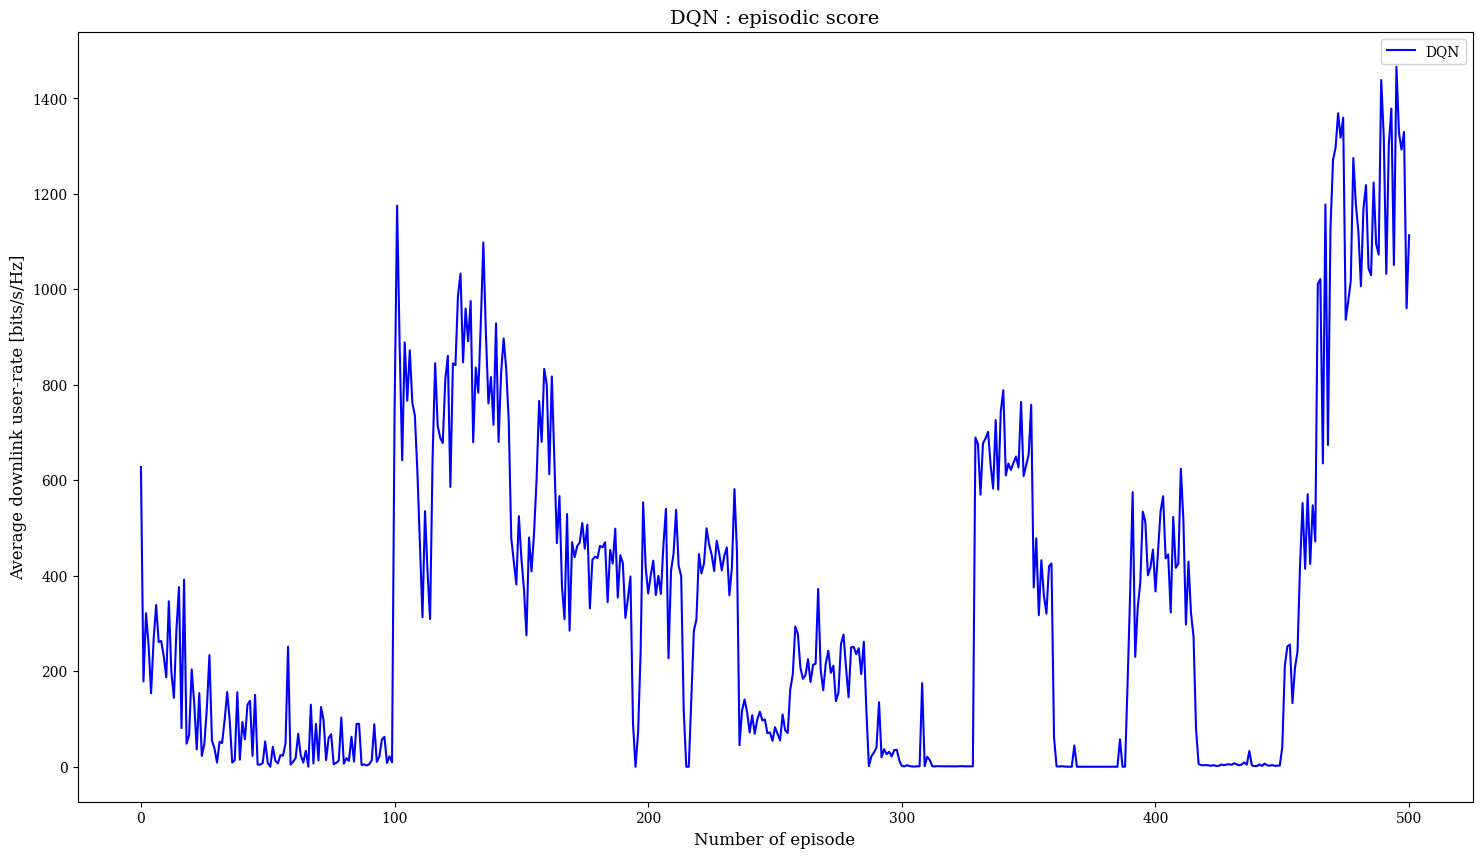

In [ ]:
EPISODES = 500

env = M_MIMOEnv(N = 7, M = 32, K = 10)

if __name__ == "__main__":
  antenna, scores, DL_rates = [], [], []

  # GET STATE, ACTION SIZE OF CUSTOM ENV.
  state_size = env.observation_space.shape[0]
  action_size = env.action_space.n

  # CREATE DQN AGENT
  agent = DQNAgent(state_size, action_size, test_mode = False)
  scores, episodes, = [], []

  for e in range(EPISODES+1):
    done = False
    score  = 0
    state = env.reset()

    state = np.reshape(state, [1, state_size])

    # LEARNING <STATE, ACTION, REWARD, NEXT STATE> COLLECTED FOR EACH EPIOSDE
    while not done:
      action = agent.get_action(state)

      next_state, reward, done, info, downlink_rate = env.step(action)
      next_state = np.reshape(next_state, [1, state_size])
      reward = reward * 10e-9
      agent.append_sample(state, action, reward, next_state, done)
      agent.train_model()

      # we use downlink user-rate as reward, but the values includes some panlty.
      score += reward
      state = next_state

      # PREDICT & UPDATE TARGET MODEL
      if done:
        agent.update_target_model()

        scores.append(score)
        episodes.append(e)
        # [SE] : equal 32.549863944255456, random 31.5269132670662, max 34.099149361187806, maxprob 37.888718763588415
        print('[{}] DQN Score {}'.format(e, score))

    if e % 50 == 0:
      print("================ save your model ================")
      agent.model.save_weights("./M_MIMO_DQN.h5")

  # PLOT THE SOCRE ACCORDING TO THE EPISODE
  plt.figure(figsize=(18,10))
  pylab.plot(episodes, scores, 'b')
  plt.xlabel('Number of episode', fontsize = 12)
  plt.ylabel('Average downlink user-rate [bits/s/Hz]', fontsize = 12)
  plt.title('DQN : episodic score', fontsize = 14)
  plt.legend(['DQN'])
  plt.savefig('DQN.png', dpi=300)

  # dataframe = pd.DataFrame({'Episode' : episodes, 'Score' : scores, 'downlink_rate' : DL_rates, 'transmit_power' : BS_powers, 'EE' : EEs})
  # dataframe.to_csv('train_DQN.csv', index = False, header=['Episode', 'Score', 'downlink_rate', 'transmit_power', 'EE'])

Episode 1 - DQN Score: 331.97, Equal: 30.27, Random: 27.21, Max: 31.91, MaxProb: 38.61
Episode 2 - DQN Score: 70.16, Equal: 29.01, Random: 27.25, Max: 30.49, MaxProb: 36.80
Episode 3 - DQN Score: 111.25, Equal: 27.75, Random: 26.45, Max: 29.13, MaxProb: 34.56
Episode 4 - DQN Score: 387.77, Equal: 27.15, Random: 25.14, Max: 28.61, MaxProb: 34.44
Episode 5 - DQN Score: 240.76, Equal: 30.30, Random: 28.63, Max: 31.73, MaxProb: 37.54
Episode 6 - DQN Score: 146.74, Equal: 28.47, Random: 26.83, Max: 29.83, MaxProb: 35.10
Episode 7 - DQN Score: 338.91, Equal: 34.19, Random: 33.21, Max: 35.82, MaxProb: 42.24
Episode 8 - DQN Score: 311.43, Equal: 30.72, Random: 25.35, Max: 32.09, MaxProb: 37.19
Episode 9 - DQN Score: 359.38, Equal: 35.17, Random: 32.93, Max: 36.72, MaxProb: 42.74
Episode 10 - DQN Score: 289.88, Equal: 28.71, Random: 26.71, Max: 30.21, MaxProb: 36.34
Episode 11 - DQN Score: 208.63, Equal: 28.16, Random: 27.39, Max: 29.63, MaxProb: 35.43
Episode 12 - DQN Score: 521.83, Equal: 33.

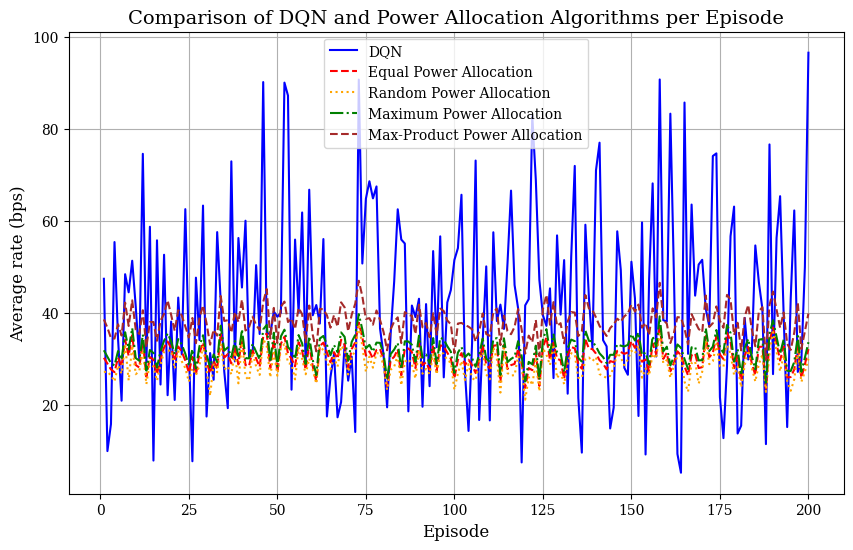

In [ ]:
# Initialize the environment
env = M_MIMOEnv(N=7, M=32, K=10)

# Number of episodes
episodes = 200
dqn_rates = []  # Store DQN performance per episode
equal_rates = []
random_rates = []
maximum_rates = []
maxprob_rates = []

# Train the DQN and dynamically compute rates for each algorithm per episode
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size, test_mode=True)

for e in range(1, episodes + 1):
    # Reset environment
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    score = 0

    while not done:
        # DQN action and reward
        action = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # agent.append_sample(state, action, reward, next_state, done)
        # agent.train_model()
        reward = reward * 10e-9
        score += reward
        state = next_state

    # Update target model
    agent.update_target_model()

    # Store DQN performance for the current episode
    dqn_rates.append(score / env.N)
     # dqn_rates.append(score )

    # Compute power allocation algorithm performances for the current episode
    equal_rates.append(10e-9*env.equal_PA() / env.N)
    random_rates.append(10e-9*env.random_PA()/ env.N)
    maximum_rates.append(10e-9*env.maximum_PA()/ env.N)
    maxprob_rates.append(10e-9*env.maxprob_PA()/ env.N)

    print(f"Episode {e} - DQN Score: {score:.2f}, Equal: {equal_rates[-1]:.2f}, Random: {random_rates[-1]:.2f}, Max: {maximum_rates[-1]:.2f}, MaxProb: {maxprob_rates[-1]:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, episodes + 1), dqn_rates, label='DQN', color='blue', linestyle='-')
plt.plot(range(1, episodes + 1), equal_rates, label='Equal Power Allocation', color='red', linestyle='--')
plt.plot(range(1, episodes + 1), random_rates, label='Random Power Allocation', color='orange', linestyle=':')
plt.plot(range(1, episodes + 1), maximum_rates, label='Maximum Power Allocation', color='green', linestyle='-.')
plt.plot(range(1, episodes + 1), maxprob_rates, label='Max-Product Power Allocation', color='brown', linestyle='--')

# Customize the plot
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average rate (bps)', fontsize=12)
plt.title('Comparison of DQN and Power Allocation Algorithms per Episode', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Save the plot
plt.savefig('comparison_dqn_vs_power_allocations_per_episode.png', dpi=300)

# Show the plot
plt.show()

# **4 - Double Deep Q-Network (DDQN) Agent for Power Allocation** <a name="ddqn"></a>

This DDQN agent enhances the traditional DQN by reducing overestimation bias through the use of a Double Q-learning approach, where the main and target Q-networks have distinct roles.

---

## 4.1 - Initialization (`__init__`):
- **Parameters**:
  - **`state_size`**: Dimensionality of the environment's state.
  - **`action_size`**: Number of possible actions (power levels) the agent can choose from.
  - **`test_mode`**: Boolean flag to load a pre-trained model if set to `True`.
- **Hyperparameters**:
  - **Discount factor** (`self.discount_factor`): Importance of future rewards (set to 0.99 here).
  - **Learning rate** (`self.learning_rate`): Step size for the optimizer.
  - **Epsilon parameters** (`epsilon`, `epsilon_decay`, `epsilon_min`): For the epsilon-greedy policy, where `epsilon` controls randomness, decaying over time to `epsilon_min`.
  - **Replay memory** (`self.memory`): Stores past experiences for replay, up to a maximum of 50,000.
- **Models**:
  - Creates two models:
    - **Main Q-network**: Estimates Q-values and selects actions.
    - **Target Q-network**: Stabilizes training by providing Q-value estimates.
  - If `test_mode` is `True`, loads pre-trained weights from `M_MIMO_DDQN.h5`.

---

## 4.2 - Neural Network Architecture (`build_model`)
- **Layers**:
  - Input layer with 128 units, two hidden layers of 64 units each (all with ReLU activation), and an output layer with `action_size` units (linear activation for Q-values).
  - Compiled with Mean Squared Error (MSE) loss and `Adam` optimizer.
  - Includes dropout and batch normalization for regularization and improved stability.

---

## 4.3 - Target Model Update (`update_target_model`)
- Copies weights from the main model to the target model periodically, reducing training oscillations and ensuring a more stable learning process.

---

## 4.4 - Action Selection (`get_action`)
- **Epsilon-Greedy Policy**:
  - With probability `epsilon`, selects a random action for exploration.
  - Otherwise:
    - Predicts Q-values for the current state using the main model.
    - Selects the action with the highest Q-value (exploitation).
  - **Boltzmann Policy**: Can be optionally incorporated for temperature-based stochastic action selection.

---

## 4.5 - Experience Replay (`append_sample`)
- **Memory Storage**:
  - Appends tuples of `(state, action, reward, next_state, done)` to replay memory, enabling the agent to learn from past experiences.
  - Gradually reduces `epsilon` for less exploration and more exploitation as training progresses.

---

## 4.6 - Training the Model (`train_model`)
- **Sampling**:
  - Randomly samples a mini-batch of experiences from memory (up to `batch_size` or the memory’s current length).
  - Constructs input states (`states`) and next states (`next_states`) from the mini-batch for training.
- **Double DQN Update**:
  - For each sample:
    - If terminal (`done=True`), sets the Q-value of the action to the reward.
    - Otherwise:
      - **Action Selection (Main Model)**: Determines the best action (`best_action`) for the next state.
      - **Value Estimation (Target Model)**: Uses the target model to estimate the value of the `best_action`.
      - Updates Q-value using the Bellman equation:  
        \[
        Q(s, a) = r + \gamma \cdot Q_{\text{target}}(s', a^*)
        \]
        where \(a^*\) is selected by the main model.
- **Model Training**:
  - Fits the model on the mini-batch data to minimize the error between target and predicted Q-values.

---

## Summary

The **Double Deep Q-Network (DDQN)** improves upon DQN by mitigating overestimation of Q-values. It achieves this by decoupling action selection (main model) and value estimation (target model) during training. This results in a more robust and stable learning process, especially for environments with continuous or complex state-action spaces. Experience replay and a target Q-network further enhance stability and efficiency. The agent balances exploration and exploitation through an epsilon-greedy policy, with optional support for Boltzmann policies.

In [ ]:
class DDQNAgent:
    def __init__(self, state_size, action_size, test_mode):
        # Environment-specific variables
        self.state_size = state_size
        self.action_size = action_size
        self.test_mode = test_mode

        # Hyperparameters
        self.discount_factor = 0.99
        self.learning_rate = 1e-4
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.train_start = 1000
        self.reward_clipping = 10

        # Replay memory
        self.memory = deque(maxlen=50000)

        # Model initialization
        self.model = self.build_model()  # Main Q-network
        self.target_model = self.build_model()  # Target Q-network
        self.update_target_model()  # Initialize target model with main model's weights

        # Load pretrained model if in test mode
        if self.test_mode:
            self.model.load_weights("./M_MIMO_DDQN.h5")
            self.epsilon=0
            # self.epsilon_decay=0

    def build_model(self):
        # Build the neural network
        model = Sequential()
        model.add(Dense(256, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))  # Prevent overfitting
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # Copy weights from the main model to the target model
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        # Epsilon-greedy policy for exploration vs exploitation
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def append_sample(self, state, action, reward, next_state, done):
        # Clip rewards to stabilize training
        reward = np.clip(reward, -self.reward_clipping, self.reward_clipping)
        self.memory.append((state, action, reward, next_state, done))
        if not self.test_mode and self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train_model(self):
        if len(self.memory) < self.train_start:
            return

        # Sample a mini-batch from memory
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        states = np.zeros((batch_size, self.state_size))
        next_states = np.zeros((batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        # Predict Q-values for the current and next states
        target = self.model.predict(states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)  # Main Q-network for action selection
        target_val = self.target_model.predict(next_states, verbose=0)  # Target Q-network for value estimation

        for i in range(batch_size):
            # Double DQN update
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                # Use the main model to select the best action
                best_action = np.argmax(target_next[i])
                # Use the target model to estimate the value of the best action
                target[i][actions[i]] = rewards[i] + self.discount_factor * target_val[i][best_action]

        # Train the main model
        self.model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)


## 4.7 - DDQN Model Training and Evaluation

The **Double Deep Q-Network (DDQN)** improves upon the DQN algorithm by addressing the overestimation bias in Q-value predictions. It achieves this by decoupling action selection from value estimation using two separate networks: the **main Q-network** and the **target Q-network**.

---

### Key Components

1. **Main Q-Network**:
   - Predicts Q-values for the current state.
   - Used for action selection in the Double Q-learning update.

2. **Target Q-Network**:
   - Provides stable Q-value estimates for the chosen action during training.

3. **Replay Memory**:
   - Stores experiences (`state, action, reward, next_state, done`) to train the network using random samples, reducing correlation between consecutive experiences.

---

### 4.7.1 - Training Loop

#### Initialization:
- The environment and agent are instantiated with specific configurations (`M`, `N`, `K` values representing BS antennas, cells, and UEs, respectively).
- State and action sizes are extracted to define the agent.

#### Training Process:
- The agent interacts with the environment over multiple episodes, collecting experiences and updating its networks.
- After every episode:
  - The target Q-network is synchronized with the main Q-network.
  - The model weights are periodically saved.

#### Episodic Scoring:
- The score for each episode is logged to evaluate the agent’s performance over time.

---

### 4.7.2 - Plotting Results

- Episodic scores are plotted as the primary metric to visualize learning progress.
- Each configuration (`M`, `N`, `K`) results in a separate plot for better comparison across different setups.

---

### Code Summary

#### Key Features:
- Epsilon-greedy policy for balancing exploration and exploitation.
- Double Q-learning update:
  - Main Q-network selects the best action.
  - Target Q-network evaluates the value of the selected action.
- Scores are saved and plotted to analyze training effectiveness.

---

[0] DDQN Score: 292.4880570263739
==== Saving DDQN model ====
[1] DDQN Score: 343.4683734488831
[2] DDQN Score: 249.16375872459855
[3] DDQN Score: 264.04561626759016
[4] DDQN Score: 240.97688812324165
[5] DDQN Score: 67.92273790032485
[6] DDQN Score: 519.6370196765985
[7] DDQN Score: 273.921142819771
[8] DDQN Score: 226.59992299150196
[9] DDQN Score: 503.72080428403876
[10] DDQN Score: 436.18292832704395
[11] DDQN Score: 298.67058515968847
[12] DDQN Score: 675.8332244008517
[13] DDQN Score: 480.8186047045185
[14] DDQN Score: 473.59398885595397
[15] DDQN Score: 679.4463493102834
[16] DDQN Score: 546.2016468217969
[17] DDQN Score: 509.0424199373346
[18] DDQN Score: 444.54988583863667
[19] DDQN Score: 637.9217916426857
[20] DDQN Score: 343.0310516766124
[21] DDQN Score: 515.2016238592147
[22] DDQN Score: 188.761887089039
[23] DDQN Score: 523.4976796357797
[24] DDQN Score: 628.0444071199427
[25] DDQN Score: 657.6098593062189
[26] DDQN Score: 796.4642874050718
[27] DDQN Score: 672.100055060

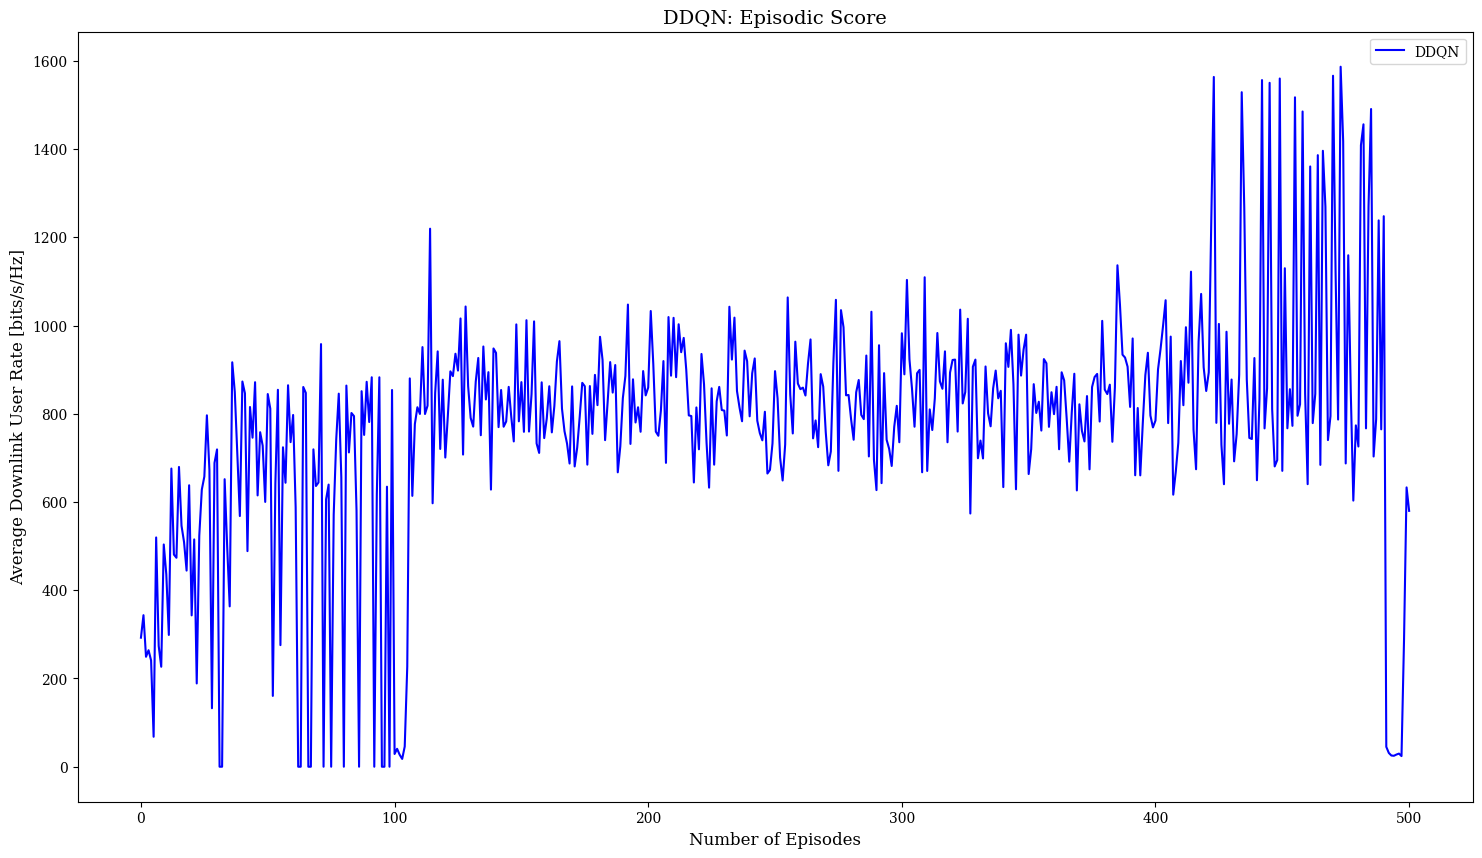

In [ ]:
# Define the environment and DDQN agent parameters
EPISODES = 500
env = M_MIMOEnv(N=7, M=32, K=10)

if __name__ == "__main__":
    antenna, scores, DL_rates = [], [], []

    # Get state and action sizes from the environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create the DDQN agent
    agent = DDQNAgent(state_size, action_size, test_mode=False)
    scores, episodes = [], []

    for e in range(EPISODES + 1):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        # Episode loop: Collect <state, action, reward, next state> for learning
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info, downlink_rate = env.step(action)
            reward = reward * 10e-9
            next_state = np.reshape(next_state, [1, state_size])

            # Append the experience to memory and train the model
            agent.append_sample(state, action, reward, next_state, done)
            agent.train_model()

            # Accumulate rewards and update state

            score += reward
            state = next_state

            # End-of-episode updates
            if done:
                agent.update_target_model()
                scores.append(score)
                episodes.append(e)
                print('[{}] DDQN Score: {}'.format(e, score))

        # Save model weights every 50 episodes
        if e % 50 == 0:
            print("==== Saving DDQN model ====")
            agent.model.save_weights("./M_MIMO_DDQN.h5")

    # Plotting the episodic scores
    plt.figure(figsize=(18, 10))
    pylab.plot(episodes, scores, 'b')
    plt.xlabel('Number of Episodes', fontsize=12)
    plt.ylabel('Average Downlink User Rate [bits/s/Hz]', fontsize=12)
    plt.title('DDQN: Episodic Score', fontsize=14)
    plt.legend(['DDQN'])
    plt.savefig('DDQN.png', dpi=300)

    # Optional: Save data to CSV for further analysis
    # dataframe = pd.DataFrame({'Episode': episodes, 'Score': scores})
    # dataframe.to_csv('train_DDQN.csv', index=False, header=['Episode', 'Score'])


# **5. Rainbow DQN Agent for Power Allocation** <a name="rain"></a>

The Rainbow DQN algorithm combines several key enhancements to the traditional Deep Q-Network (DQN), making it one of the most robust and feature-rich algorithms for reinforcement learning. This implementation includes components like **dueling network architecture**, **prioritized experience replay**, **multi-step learning**, and **noisy layers**, which collectively improve exploration, stability, and learning efficiency.

---

## **5.1 - Initialization (`__init__`)**
- **Parameters**:
  - **`state_size`**: Dimensionality of the environment's state.
  - **`action_size`**: Number of possible discrete actions.
  - **`test_mode`**: Boolean flag for enabling or disabling training-specific behavior.
- **Hyperparameters**:
  - **Discount factor** (`self.discount_factor`): Controls the importance of future rewards.
  - **Epsilon** (`self.epsilon`): Initial exploration rate for epsilon-greedy policy.
  - **Epsilon decay** (`self.epsilon_decay`): Rate at which exploration decreases.
  - **Replay buffer size** (`self.memory`): Capacity of the prioritized replay memory.
  - **Learning rate** (`self.learning_rate`): Step size for the optimizer.
  - **Reward clipping** (`self.reward_clipping`): Bounds rewards to stabilize training.
  - **Multi-step learning** (`self.n_steps`): Number of steps to compute multi-step rewards.
  - **Prioritization exponent** (`self.alpha`): Controls the degree of prioritization in experience replay.

---

## **5.2 - Neural Network Architecture (`build_model`)**
This implementation uses a **dueling network architecture** with **noisy layers**, designed to improve exploration and efficiency.

1. **Feature Extraction**:
   - Two **NoisyDense** layers with 128 units each, using ReLU activation, help the agent explore effectively by adding noise to weights.

2. **Dueling Architecture**:
   - **State Value Stream**:
     - Outputs a single value representing the overall state value.
   - **Advantage Value Stream**:
     - Outputs action-specific advantages, adjusted to ensure consistent Q-value computation.
   - Combines the two streams to compute final Q-values using:
     \[
     Q(s, a) = V(s) + \left(A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a') \right)
     \]

3. **Output**:
   - A Q-value for each possible action.

4. **Optimizer and Loss**:
   - Uses the Adam optimizer with Mean Squared Error (MSE) loss.

---

## **5.3 - Action Selection (`get_action`)**
- **Exploration vs. Exploitation**:
  - Combines **epsilon-greedy policy** with Q-value predictions:
    - With probability \( \epsilon \), selects a random action for exploration.
    - Otherwise, selects the action with the highest Q-value.
- **Integration with Noisy Layers**:
  - As training progresses, the reliance on noisy layers reduces the need for epsilon decay.

---

## **5.4 - Replay Memory and Prioritized Sampling**
- **Replay Memory**:
  - Stores transitions \((state, action, reward, next\_state, done)\) with a fixed maximum capacity.
- **Prioritized Experience Replay**:
  - Assigns a priority to each transition based on its TD-error.
  - Sampling probabilities are computed as:
    \[
    P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}
    \]
    Where \( \alpha \) controls the prioritization strength.
- **Batch Sampling**:
  - Samples transitions using computed probabilities, ensuring important experiences are revisited more frequently.

---

## **5.5 - Training Process (`train_model`)**
- **Inputs**:
  - States, actions, rewards, next states, and done flags sampled from the prioritized replay memory.
- **Steps**:
  1. **Multi-step Learning**:
     - Computes \(n\)-step rewards by summing discounted rewards for up to \(n\) steps, ensuring better reward estimation.
  2. **Target Computation**:
     - Uses **Double DQN** to select the best action using the main network and evaluate its value using the target network:
       \[
       Q(s, a) = r + \gamma^n \max_a' Q_{\text{target}}(s', a')
       \]
  3. **Priority Update**:
     - Updates priorities in the replay buffer based on the TD-error for each sampled transition:
       \[
       \delta = \left| Q_{\text{predicted}}(s, a) - Q_{\text{target}}(s, a) \right|
       \]

---

## **5.6 - Multi-Step Learning**
- **Purpose**:
  - Improves learning by incorporating future rewards over multiple steps.
- **Process**:
  - Accumulates rewards for \(n\) steps, discounting each step:
    \[
    R_t = \sum_{k=0}^{n-1} \gamma^k r_{t+k}
    \]

---

## **5.7 - Regular Target Model Updates**
- **Procedure**:
  - Periodically copies weights from the main Q-network to the target network to stabilize learning.
- **Frequency**:
  - Updates every few training steps (configurable).

---

### **Summary**
This Rainbow DQN agent integrates multiple advanced components to improve learning and exploration:
- **Noisy Networks** for effective exploration without explicit epsilon-greedy policies.
- **Dueling Architecture** for stable Q-value estimation.
- **Prioritized Experience Replay** for sampling critical transitions.
- **Multi-step Learning** for more accurate reward computation.
- **Double Q-Learning** to reduce overestimation bias.



In [ ]:
import numpy as np
import random
from collections import deque
# !pip install tensorflow --upgrade
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
# import tensorflow_probability as tfp

In [ ]:
class NoisyDense(tf.keras.layers.Layer):
    """
    Noisy Dense Layer using independent Gaussian noise,
    as defined by Fortunato et al. (2017).
    """

    def __init__(self, units, sigma_zero=0.5, use_bias=True, **kwargs):
        """
        Args:
            units (int): Number of output features (neurons).
            sigma_zero (float): Initial noise scaling factor.
            use_bias (bool): Whether to include bias.
        """
        super(NoisyDense, self).__init__(**kwargs)
        self.units = units
        self.sigma_zero = sigma_zero
        self.use_bias = use_bias

    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        sigma_init = self.sigma_zero / np.sqrt(input_dim)

        # Weight and bias parameters
        self.kernel_mu = self.add_weight(
            shape=(input_dim, self.units),
            initializer="he_uniform",
            trainable=True,
            name="kernel_mu"
        )
        self.kernel_sigma = self.add_weight(
            shape=(input_dim, self.units),
            initializer=tf.constant_initializer(sigma_init),
            trainable=True,
            name="kernel_sigma"
        )

        if self.use_bias:
            self.bias_mu = self.add_weight(
                shape=(self.units,),
                initializer="zeros",
                trainable=True,
                name="bias_mu"
            )
            self.bias_sigma = self.add_weight(
                shape=(self.units,),
                initializer=tf.constant_initializer(sigma_init),
                trainable=True,
                name="bias_sigma"
            )
        else:
            self.bias_mu = None
            self.bias_sigma = None

    def _scale_noise(self, x):
        """
        Scales Gaussian noise using the function f(x) = sign(x) * sqrt(|x|).
        """
        return tf.sign(x) * tf.sqrt(tf.abs(x))

    def _generate_noise(self, shape):
        """
        Generates factorized Gaussian noise for weights and biases.
        """
        row_noise = self._scale_noise(tf.random.normal((shape[0], 1)))
        col_noise = self._scale_noise(tf.random.normal((1, shape[1])))
        return tf.matmul(row_noise, col_noise)

    def call(self, inputs):
        # Generate Gaussian noise for weights
        weight_noise = self._generate_noise(self.kernel_mu.shape)
        noisy_kernel = self.kernel_mu + self.kernel_sigma * weight_noise

        # Compute output
        output = tf.matmul(inputs, noisy_kernel)

        # Add bias with noise if applicable
        if self.use_bias:
            bias_noise = self._scale_noise(tf.random.normal(self.bias_mu.shape))
            noisy_bias = self.bias_mu + self.bias_sigma * bias_noise
            output += noisy_bias

        return output

In [ ]:
class RainbowDQNAgent:
    def __init__(self, state_size, action_size, test_mode):
        # Environment-specific variables
        self.state_size = state_size
        self.action_size = action_size
        self.test_mode = test_mode

        # Hyperparameters
        self.discount_factor = 0.99
        self.learning_rate = 1e-3
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 256
        self.train_start = 1000
        self.reward_clipping = 10
        self.n_steps = 3  # Multi-step learning

        # Replay memory with priorities
        self.memory = deque(maxlen=50000)
        self.priority = deque(maxlen=50000)
        self.alpha = 0.6  # Prioritization exponent

        # Model initialization
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

        if self.test_mode:
            self.model.load_weights("M_MIMO_RainbowDQN.h5")
            self.epsilon=0
            self.epsilon_decay=0

    def build_model(self):
      """
      Build a dueling network with noisy layers.
      """
      input_layer = Input(shape=(self.state_size,))

     # Feature extraction with NoisyDense
      x = NoisyDense(128, sigma_zero=0.5)(input_layer)
      x = tf.keras.layers.ReLU()(x)
      x = NoisyDense(128, sigma_zero=0.5)(x)
      x = tf.keras.layers.ReLU()(x)

      # Dueling architecture
      # State value
      value = NoisyDense(1, sigma_zero=0.5)(x)

      # Advantage values
      advantage = NoisyDense(self.action_size, sigma_zero=0.5)(x)
      advantage_mean = Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
      advantage = Add()([advantage, -advantage_mean])

      # Combine state and advantage
      q_values = Add()([value, advantage])

      model = Model(inputs=input_layer, outputs=q_values)
      model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
      return model

    def update_target_model(self):
        """Copy weights from the main model to the target model."""
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        """Epsilon-greedy policy for exploration vs exploitation."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def append_sample(self, state, action, reward, next_state, done):
        """Add transition to prioritized replay buffer."""
        reward = np.clip(reward, -self.reward_clipping, self.reward_clipping)
        self.memory.append((state, action, reward, next_state, done))
        # Default priority
        self.priority.append(max(self.priority) if self.priority else 1.0)

        if not self.test_mode and self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def sample_minibatch(self):
        """Sample a minibatch using prioritized experience replay."""
        priorities = np.array(self.priority) ** self.alpha
        probs = priorities / np.sum(priorities)
        indices = np.random.choice(len(self.memory), self.batch_size, p=probs)
        batch = [self.memory[i] for i in indices]
        return batch, indices
    def train_model(self):
        if len(self.memory) < self.train_start:
            return

        # Sample a mini-batch from prioritized replay memory
        batch, indices = self.sample_minibatch()

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = batch[i][0]
            actions.append(batch[i][1])
            rewards.append(batch[i][2])
            next_states[i] = batch[i][3]
            dones.append(batch[i][4])

        # Predict Q-values for the current and next states
        target = self.model.predict(states, verbose=0)
        target_val = self.target_model.predict(next_states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)

        for i in range(self.batch_size):
            # Multi-step reward calculation
            n_step_reward = 0
            for k in range(self.n_steps):
                if i + k < len(batch):  # Avoid going out of bounds
                    n_step_reward += (self.discount_factor ** k) * batch[i + k][2]
                    if batch[i + k][4]:  # Stop if a terminal state is reached
                        break

            # Double DQN: select the best action from the main model
            best_action = np.argmax(target_next[i])
            if dones[i]:
                target[i][actions[i]] = n_step_reward  # No future reward after terminal state
            else:
                target[i][actions[i]] = n_step_reward + (self.discount_factor ** self.n_steps) * target_val[i][best_action]

        # Train the main model
        self.model.fit(states, target, batch_size=self.batch_size, epochs=1, verbose=0)

        # Update priorities using the absolute TD error
        for i, idx in enumerate(indices):
            td_error = abs(target[i][actions[i]] - self.model.predict(states[i].reshape(1, -1), verbose=0)[0][actions[i]])
            self.priority[idx] = td_error + 1e-6  # Add small constant to avoid zero priority




In [ ]:
# Define the environment and DDQN agent parameters
EPISODES = 500
env = M_MIMOEnv(N=7, M=32, K=10)

if __name__ == "__main__":
    antenna, scores, DL_rates = [], [], []

    # Get state and action sizes from the environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Create the ReinbowDQN agent
    agent = RainbowDQNAgent(state_size, action_size, test_mode=False)
    scores, episodes = [], []

    for e in range(EPISODES + 1):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        # Episode loop: Collect <state, action, reward, next state> for learning
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info, downlink_rate = env.step(action)
            reward = reward * 10e-9
            next_state = np.reshape(next_state, [1, state_size])


            # Append the experience to memory and train the model
            agent.append_sample(state, action, reward, next_state, done)
            agent.train_model()

            # Accumulate rewards and update state
            score += reward
            state = next_state

            # End-of-episode updates
            if done:
                agent.update_target_model()
                scores.append(score)
                episodes.append(e)
                print('[{}] Rainbow DQN Score: {}'.format(e, score))

        # Save model weights every 50 episodes
        if e % 50 == 0:
            print("==== Saving DDQN model ====")
            agent.model.save_weights("./M_MIMO_RainbowDQN.h5")

    # Plotting the episodic scores
    plt.figure(figsize=(18, 10))
    pylab.plot(episodes, scores, 'b')
    plt.xlabel('Number of Episodes', fontsize=12)
    plt.ylabel('Average Downlink User Rate [bits/s/Hz]', fontsize=12)
    plt.title('Rainbow DQN: Episodic Score', fontsize=14)
    plt.legend(['Rainbow DQN'])
    plt.savefig('Rainbow DQN.png', dpi=300)


# Performance comparison between DQN, Rainbow DQN and baseline algorithms

In [ ]:
EPISODES = 500
results = {
    "episode": [],
    "rainbow_score": [],
    "ddqn_score": [],
    "dqn_score": [],
    "equal_rate": [],
    "random_rate": [],
    "maximum_rate": [],
    "maxprob_rate": []
}
if __name__ == "__main__":
    # Define the environment for all models
    env_rainbow = M_MIMOEnv(N=7, M=32, K=10)
    env_ddqn = M_MIMOEnv(N=7, M=32, K=10)
    env_dqn = M_MIMOEnv(N=7, M=32, K=10)

    # Get state and action sizes from the environments
    state_size = env_rainbow.observation_space.shape[0]
    action_size = env_rainbow.action_space.n

    # Initialize agents
    rainbow_agent = RainbowDQNAgent(state_size, action_size, test_mode=False)
    ddqn_agent = DDQNAgent(state_size, action_size, test_mode=False)
    dqn_agent = DQNAgent(state_size, action_size, test_mode=False)

    # Initialize performance scores
    scores_rainbow, scores_ddqn, scores_dqn = [], [], []
    equal_rates, random_rates, maximum_rates, maxprob_rates = [], [], [], []

    for e in range(EPISODES + 1):
        # Reset environments and states for each agent
        state_rainbow = env_rainbow.reset()
        state_ddqn = env_ddqn.reset()
        state_dqn = env_dqn.reset()

        state_rainbow = np.reshape(state_rainbow, [1, state_size])
        state_ddqn = np.reshape(state_ddqn, [1, state_size])
        state_dqn = np.reshape(state_dqn, [1, state_size])

        done_rainbow = done_ddqn = done_dqn = False
        score_rainbow = score_ddqn = score_dqn = 0

        while not (done_rainbow and done_ddqn and done_dqn):
            # Rainbow DQN agent step
            if not done_rainbow:
                action_rainbow = rainbow_agent.get_action(state_rainbow)
                next_state_rainbow, reward_rainbow, done_rainbow, _, _ = env_rainbow.step(action_rainbow)
                reward_rainbow *= 10e-9
                next_state_rainbow = np.reshape(next_state_rainbow, [1, state_size])
                rainbow_agent.append_sample(state_rainbow, action_rainbow, reward_rainbow, next_state_rainbow, done_rainbow)
                rainbow_agent.train_model()
                score_rainbow += reward_rainbow
                state_rainbow = next_state_rainbow

            # DDQN agent step
            if not done_ddqn:
                action_ddqn = ddqn_agent.get_action(state_ddqn)
                next_state_ddqn, reward_ddqn, done_ddqn, _, _ = env_ddqn.step(action_ddqn)
                reward_ddqn *= 10e-9
                next_state_ddqn = np.reshape(next_state_ddqn, [1, state_size])
                ddqn_agent.append_sample(state_ddqn, action_ddqn, reward_ddqn, next_state_ddqn, done_ddqn)
                ddqn_agent.train_model()
                score_ddqn += reward_ddqn
                state_ddqn = next_state_ddqn

            # DQN agent step
            if not done_dqn:
                action_dqn = dqn_agent.get_action(state_dqn)
                next_state_dqn, reward_dqn, done_dqn, _, _ = env_dqn.step(action_dqn)
                reward_dqn *= 10e-9
                next_state_dqn = np.reshape(next_state_dqn, [1, state_size])
                dqn_agent.append_sample(state_dqn, action_dqn, reward_dqn, next_state_dqn, done_dqn)
                dqn_agent.train_model()
                score_dqn += reward_dqn
                state_dqn = next_state_dqn

        # Evaluate baseline algorithms
        equal_rates.append(10e-9 * env_rainbow.equal_PA() / env_rainbow.N)
        random_rates.append(10e-9 * env_rainbow.random_PA() / env_rainbow.N)
        maximum_rates.append(10e-9 * env_rainbow.maximum_PA() / env_rainbow.N)
        maxprob_rates.append(10e-9 * env_rainbow.maxprob_PA() / env_rainbow.N)

        # End-of-episode updates
        rainbow_agent.update_target_model()
        ddqn_agent.update_target_model()
        dqn_agent.update_target_model()

        scores_rainbow.append(score_rainbow/ env_rainbow.N)
        scores_ddqn.append(score_ddqn/ env_ddqn.N)
        scores_dqn.append(score_dqn/ env_dqn.N)

        results["episode"].append(e)
        results["rainbow_score"].append(scores_rainbow[-1])
        results["ddqn_score"].append(scores_ddqn[-1])
        results["dqn_score"].append(scores_dqn[-1])
        results["equal_rate"].append(equal_rates[-1])
        results["random_rate"].append(random_rates[-1])
        results["maximum_rate"].append(maximum_rates[-1])
        results["maxprob_rate"].append(maxprob_rates[-1])

        print(f"[{e}] Rainbow DQN Score: {score_rainbow}, DDQN Score: {score_ddqn}, DQN Score: {score_dqn}, Equal: {equal_rates[-1]:.2f}, Random: {random_rates[-1]:.2f}, Max: {maximum_rates[-1]:.2f}, MaxProb: {maxprob_rates[-1]:.2f}")

        # Save model weights every 50 episodes
        if e % 50 == 0:
            print("==== Saving models ====")
            rainbow_agent.model.save_weights("./M_MIMO_RainbowDQN.h5")
            ddqn_agent.model.save_weights("./M_MIMO_DDQN.h5")
            dqn_agent.model.save_weights("./M_MIMO_DQN.h5")
    df = pd.DataFrame(results)
    df.to_csv("training_scores.csv", index=False)
    print("Scores saved to training_scores.csv")

print("Scores saved to training_scores.csv")




/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[0] Rainbow DQN Score: 86.93660585982461, DDQN Score: 458.3496599603558, DQN Score: 345.31340792966313, Equal: 37.94, Random: 35.80, Max: 39.68, MaxProb: 46.53
==== Saving models ====
[1] Rainbow DQN Score: 137.5012114745446, DDQN Score: 483.72866905636647, DQN Score: 213.9454997025585, Equal: 27.07, Random: 26.39, Max: 28.35, MaxProb: 33.27
[2] Rainbow DQN Score: 57.620718980155196, DDQN Score: 345.6521285228764, DQN Score: 39.599379117199746, Equal: 31.19, Random: 28.50, Max: 32.70, MaxProb: 38.63
[3] Rainbow DQN Score: 416.915871635741, DDQN Score: 656.4612696205224, DQN Score: 193.88746944535612, Equal: 28.87, Random: 26.63, Max: 30.50, MaxProb: 37.10
[4] Rainbow DQN Score: 231.34107611392437, DDQN Score: 249.09457158303917, DQN Score: 237.02092121146862, Equal: 31.77, Random: 30.65, Max: 33.31, MaxProb: 39.63
[5] Rainbow DQN Score: 299.8528247161317, DDQN Score: 127.27749169364297, DQN Score: 304.0333255298361, Equal: 29.53, Random: 27.77, Max: 30.95, MaxProb: 36.46
[6] Rainbow DQ

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


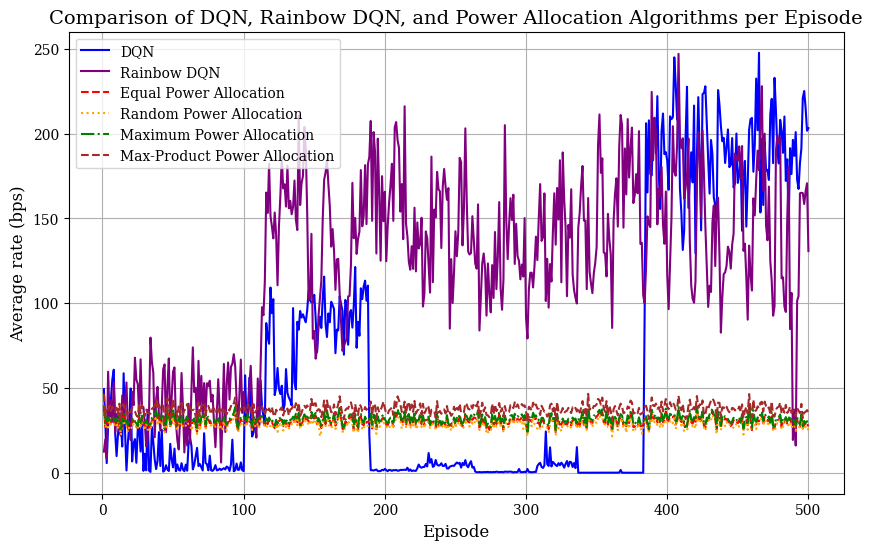

In [ ]:
# Plot the results
episodes = 500
plt.figure(figsize=(10, 6))
plt.plot(range(1, episodes + 1 ), scores_dqn[:-1], label='DQN', color='blue', linestyle='-')
# plt.plot(range(1, episodes + 1), scores_ddqn[:-1], label='DDQN', color='purple', linestyle='-')
plt.plot(range(1, episodes + 1), scores_rainbow[:-1], label='Rainbow DQN', color='purple', linestyle='-')
plt.plot(range(1, episodes + 1), equal_rates[:-1], label='Equal Power Allocation', color='red', linestyle='--')
plt.plot(range(1, episodes + 1), random_rates[:-1], label='Random Power Allocation', color='orange', linestyle=':')
plt.plot(range(1, episodes + 1), maximum_rates[:-1], label='Maximum Power Allocation', color='green', linestyle='-.')
plt.plot(range(1, episodes + 1), maxprob_rates[:-1], label='Max-Product Power Allocation', color='brown', linestyle='--')


# Customize the plot
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average rate (bps)', fontsize=12)
plt.title('Comparison of DQN, Rainbow DQN, and Power Allocation Algorithms per Episode', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Save the plot
plt.savefig('comparison_dqn_ddqn_vs_power_allocations_per_episode.png', dpi=300)

# Show the plot
plt.show()

# **6 - Proximal Policy Optimization (PPO) Agent for Power Allocation** <a name="ppo"></a>

The Proximal Policy Optimization (PPO) algorithm uses a policy-gradient-based approach with a clipped objective function, balancing exploration and exploitation while ensuring stable training. It is designed for environments with **discrete action spaces**, making it suitable for power allocation in this setup.

---

## **6.1 - Initialization (`__init__`)**
- **Parameters**:
  - **`state_size`**: Dimensionality of the environment's state.
  - **`action_size`**: Number of possible discrete actions (e.g., power levels).
- **Hyperparameters**:
  - **Discount factor** (`self.gamma`): Controls the importance of future rewards.
  - **GAE lambda** (`self.lam`): Balances bias and variance for advantage estimation.
  - **Clipping epsilon** (`self.epsilon`): Limits the change in policy between updates, improving stability.
  - **Learning rates** (`self.lr_actor` and `self.lr_critic`): Separate learning rates for the actor (policy) and critic (value function) networks.
- **Replay Buffer**:
  - Trajectories (states, actions, rewards, etc.) are stored temporarily for training after each episode.
- **Models**:
  - **Actor network**: Outputs probabilities for each discrete action.
  - **Critic network**: Predicts the value of a given state.

---

## **6.2 - Neural Network Architectures**
1. **Actor Network (`build_actor`)**:
   - **Input**: Takes the current state as input.
   - **Hidden Layers**:
     - Three fully connected layers with 256, 128, and 64 units, each using ReLU activation.
   - **Output Layer**:
     - Softmax activation to output a probability distribution over discrete actions.
   - **Optimizer**:
     - Uses `Adam` optimizer with a learning rate of `lr_actor`.

2. **Critic Network (`build_critic`)**:
   - **Input**: Similar to the actor, but predicts a single scalar value representing the state's value.
   - **Hidden Layers**:
     - Three fully connected layers identical to the actor's.
   - **Output Layer**:
     - Linear activation to output the state value.
   - **Loss Function**:
     - Mean Squared Error (MSE) to minimize the difference between predicted and target values.

---

## **6.3 - Action Selection (`get_action`)**
- **Output**:
  - A discrete action sampled from the probability distribution generated by the actor network.
  - Uses `numpy.random.choice` for stochastic sampling.
- **Procedure**:
  - The actor network predicts action probabilities for the given state.
  - An action is sampled based on these probabilities, ensuring exploration and exploitation.

---

## **6.4 - Training Process (`train`)**
- **Inputs**:
  - States, actions, rewards, `done` flags, next states, and old action probabilities collected during an episode.
- **Steps**:
  1. **Advantage Computation**:
     - Uses **Generalized Advantage Estimation (GAE)** to compute advantage values and discounted returns.
     - Combines rewards and value predictions to reduce variance.
  2. **Actor Update**:
     - Computes the probability ratio between the new and old policies for the sampled actions.
     - Uses the clipped objective function to limit updates, ensuring training stability.
     - Minimizes the actor loss using `GradientTape` and applies gradients.
  3. **Critic Update**:
     - Minimizes the mean squared error between predicted and target state values.
  - Alternates between updating the actor and critic networks.

---

## **6.5 - Generalized Advantage Estimation (`compute_gae`)**
- **Purpose**:
  - Computes the advantage function, a key component in policy gradient methods.
- **Process**:
  - Uses rewards, value predictions, and `done` flags to compute temporal differences and advantages iteratively.

---

## **6.6 - Training Loop Example**
- **Procedure**:
  - Reset the environment at the start of each episode.
  - Collect trajectories by interacting with the environment.
  - Train the actor and critic networks using the collected trajectories after each episode.
  - Monitor the total reward for performance evaluation.

---

### **Summary**
This PPO agent implements a policy-gradient approach with stability enhancements through:
- Clipping the policy objective.
- Advantage estimation with GAE.
- Separate actor and critic networks for policy and value function approximation.

By combining these features, the PPO algorithm is well-suited for discrete action spaces in power allocation tasks, offering improved exploration, robustness, and convergence stability.

In [ ]:
class PPOAgent:
    def __init__(self, state_size, action_size, lr_actor=1e-4, lr_critic=1e-3, gamma=0.99, lam=0.2, clip_value=0.2,test_mode = False):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lam = lam
        self.clip_value = clip_value

        # Build models
        self.actor = self.build_actor(lr_actor)
        self.critic = self.build_critic(lr_critic)

        if test_mode:
            self.actor.load_weights("PPO_Actor.h5")
            self.critic.load_weights("PPO_Critic.h5")

    def build_actor(self, lr):
        # Actor network
        state_input = Input(shape=(self.state_size,))
        x = Dense(256, activation="relu")(state_input)
        x = Dense(128, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        action_probs = Dense(self.action_size, activation="softmax")(x)

        model = Model(inputs=state_input, outputs=action_probs)
        return model

    def build_critic(self, lr):
        # Critic network
        state_input = Input(shape=(self.state_size,))
        x = Dense(256, activation="relu")(state_input)
        x = Dense(128, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        value = Dense(1, activation="linear")(x)

        model = Model(inputs=state_input, outputs=value)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
        return model

    def select_action(self, state):
        state = state.reshape([1, self.state_size])
        prob = self.actor.predict(state, verbose=0)[0]
        action = np.random.choice(self.action_size, p=prob)
        return action, prob

    def compute_advantages(self, rewards, values, dones, next_value):
        advantages = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * (1 - dones[i]) * next_value - values[i]
            gae = delta + self.gamma * (1 - dones[i]) * self.lam * gae
            advantages.insert(0, gae)
            next_value = values[i]
        return np.array(advantages)

    def ppo_loss(self, old_probs, advantages):
        # Define the PPO clipped loss function
        def loss(y_true, y_pred):
            prob_ratio = tf.reduce_sum(y_pred * y_true, axis=1) / tf.reduce_sum(y_true * old_probs, axis=1)
            clipped_ratio = tf.clip_by_value(prob_ratio, 1 - self.clip_value, 1 + self.clip_value)
            return -tf.reduce_mean(tf.minimum(prob_ratio * advantages, clipped_ratio * advantages))
        return loss

    def train(self, states, actions, rewards, next_states, dones, old_probs):
        values = self.critic.predict(states, verbose=0).flatten()  # Ensure values are 1D
        next_value = self.critic.predict(next_states[-1].reshape(1, -1), verbose=0)[0][0]

        # Compute advantages and discounted rewards
        advantages = self.compute_advantages(rewards, values, dones, next_value)
        discounted_rewards = advantages + values

        # Normalize advantages
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        # Train critic
        self.critic.fit(states, discounted_rewards.reshape(-1, 1), epochs=1, verbose=0, shuffle=True)

        # Train actor with PPO clipped loss
        actions_one_hot = tf.keras.utils.to_categorical(actions, num_classes=self.action_size)
        old_probs = np.array(old_probs)

        # Compile the actor with the PPO loss
        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss=self.ppo_loss(old_probs, advantages))
        self.actor.fit(states, actions_one_hot, epochs=1, verbose=0, shuffle=True)


## 6.7 - PPO Model Training and Evaluation

The **Proximal Policy Optimization (PPO)** is a policy-gradient-based reinforcement learning algorithm. It balances exploration and exploitation while maintaining stability during training through **clipped objective functions** and **advantage estimation**.

---

### Key Components

1. **Actor-Critic Framework**:
   - **Actor**: A neural network that outputs a probability distribution over actions (policy).
   - **Critic**: A neural network that approximates the value function to estimate the expected return for each state.

2. **Generalized Advantage Estimation (GAE)**:
   - Computes advantages for each state-action pair, balancing bias and variance in the estimation.

3. **Clipped Objective**:
   - Ensures that policy updates do not deviate excessively from the current policy by using a clipping range (`epsilon`).

---

### 6.7.1 - Training Loop

#### Initialization:
- Environment and agent are set up with specific `M`, `N`, and `K` values.
- The PPO agent's actor and critic networks are initialized with respective learning rates.

#### Training Process:
- For each episode:
  - The agent interacts with the environment, collecting states, actions, rewards, and probabilities of chosen actions.
  - At the end of the episode, the agent uses the collected data to:
    - Compute returns and advantages using GAE.
    - Update the actor network using the clipped PPO objective.
    - Update the critic network to minimize the value estimation error.

#### Episodic Scoring:
- Scores for each episode are logged to track training progress.

---

### 6.7.2 - Plotting Results

- Episodic scores are visualized using line plots.
- Separate plots are generated for different configurations (`M`, `N`, `K`), allowing performance comparison.

---

### Code Summary

#### Key Features:
- Probabilistic action selection using the actor network.
- Clipped objective to stabilize policy updates.
- Advantage estimation with GAE for better sample efficiency.
- Scores plotted per configuration to evaluate training performance.

#### Comparison:
- Unlike DDQN, PPO is a policy-gradient method and directly optimizes the policy, making it suitable for environments with continuous action spaces or stochastic policies.
- Both approaches plot episodic scores to evaluate and compare their effectiveness in learning optimal power allocation strategies.

Episode: 0, PPO Score: 214.30087539161866, Avg Reward (10 eps): 214.30
Episode: 1, PPO Score: 178.95311373408887, Avg Reward (10 eps): 196.63
Episode: 2, PPO Score: 244.89422396649002, Avg Reward (10 eps): 212.72
Episode: 3, PPO Score: 276.09505413410085, Avg Reward (10 eps): 228.56
Episode: 4, PPO Score: 89.32122101928981, Avg Reward (10 eps): 200.71
Episode: 5, PPO Score: 484.58680349781105, Avg Reward (10 eps): 248.03
Episode: 6, PPO Score: 683.4480110782716, Avg Reward (10 eps): 310.23
Episode: 7, PPO Score: 463.8092221387181, Avg Reward (10 eps): 329.43
Episode: 8, PPO Score: 725.7753423168494, Avg Reward (10 eps): 373.46
Episode: 9, PPO Score: 878.1304415619384, Avg Reward (10 eps): 423.93
Episode: 10, PPO Score: 474.17018429531936, Avg Reward (10 eps): 449.92
Episode: 11, PPO Score: 768.9247161800286, Avg Reward (10 eps): 508.92
Episode: 12, PPO Score: 1146.7910651099753, Avg Reward (10 eps): 599.11
Episode: 13, PPO Score: 1336.0299008141428, Avg Reward (10 eps): 705.10
Episode:

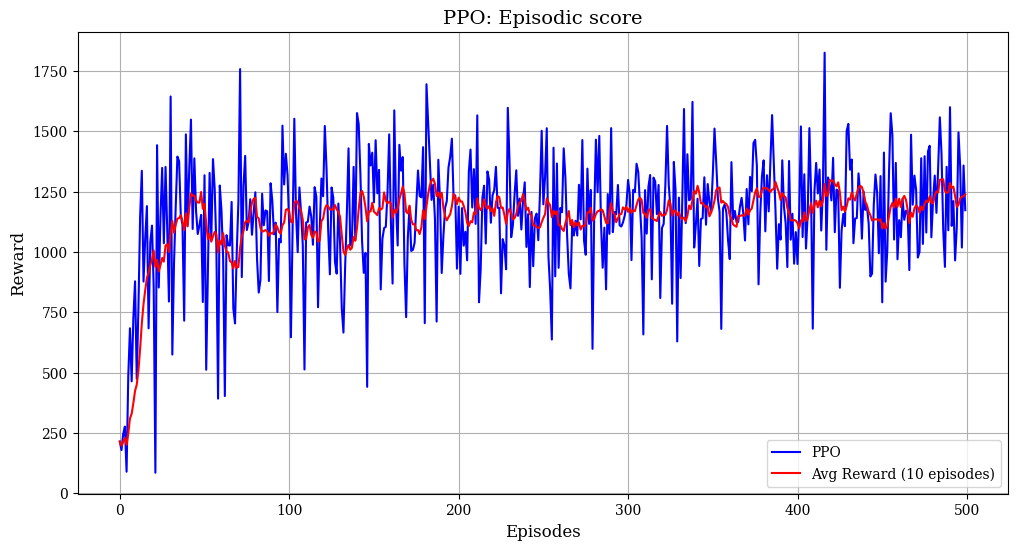

In [ ]:
EPISODES = 500
MAX_STEPS = 1000

env = M_MIMOEnv(N=7, M=32, K=10)

if __name__ == "__main__":
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = PPOAgent(state_size, action_size)
    scores, episodes, avg_rewards = [], [], []

    for e in range(EPISODES):
        state = env.reset()
        score = 0
        states, actions, rewards, probs, dones = [], [], [], [], []
        done = False

        for step in range(MAX_STEPS):
            action, prob = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            reward = reward * 10e-9

            # Store transitions
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            probs.append(prob)
            dones.append(done)

            score += reward
            state = next_state

            if done:
                break

        # Train PPO agent
        next_state = np.array([state])
        agent.train(np.array(states), np.array(actions), np.array(rewards), next_state, np.array(dones), probs)

        scores.append(score)
        episodes.append(e)
        avg_rewards.append(np.mean(scores[-10:]))  # Rolling average of last 10 episodes

        print(f"Episode: {e}, PPO Score: {score}, Avg Reward (10 eps): {avg_rewards[-1]:.2f}")

        if e % 50 == 0:
            agent.actor.save_weights(f"./PPO_Actor.h5")
            agent.critic.save_weights(f"./PPO_Critic.h5")

    # Save results to CSV
    # df = pd.DataFrame({'Episode': episodes, 'Score': scores, 'Avg Reward': avg_rewards})
    # df.to_csv('PPO_results.csv', index=False)

# Enhanced plotting
plt.figure(figsize=(12, 6))
plt.plot(episodes, scores, 'b', label='PPO')
plt.plot(episodes, avg_rewards, 'r', label='Avg Reward (10 episodes)')
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.title('PPO: Episodic score', fontsize=14)
plt.legend()
plt.grid()
plt.savefig('PPO_performance.png', dpi=300)
plt.show()

# Performance comparison between Rainbow DQN, PPO and baseline algorithms

In [ ]:

if __name__ == "__main__":
    # Define the environment
    env_rainbow = M_MIMOEnv(N=7, M=32, K=10)
    env_ppo = M_MIMOEnv(N=7, M=32, K=10)

    # Get state and action sizes from the environment
    state_size = env_rainbow.observation_space.shape[0]
    action_size = env_rainbow.action_space.n

    # Initialize Rainbow DQN Agent
    rainbow_agent = RainbowDQNAgent(state_size, action_size, test_mode=True)
    rainbow_agent.model.load_weights("./M_MIMO_RainbowDQN.h5")

    # Initialize PPO Agent
    ppo_agent = PPOAgent(state_size, action_size, test_mode=True)
    ppo_agent.actor.load_weights("./PPO_Actor.h5")
    ppo_agent.critic.load_weights("./PPO_Critic.h5")

    EPISODES = 200
    scores_rainbow, scores_ppo = [], []
    equal_rates, random_rates, maximum_rates, maxprob_rates = [], [], [], []

    for e in range(EPISODES):
        # Rainbow DQN inference
        state_rainbow = env_rainbow.reset()
        state_rainbow = np.reshape(state_rainbow, [1, state_size])
        done_rainbow = False
        score_rainbow = 0

        while not done_rainbow:
            action_rainbow = rainbow_agent.get_action(state_rainbow)
            next_state_rainbow, reward_rainbow, done_rainbow, _, _ = env_rainbow.step(action_rainbow)
            reward_rainbow *= 10e-9
            score_rainbow += reward_rainbow
            state_rainbow = np.reshape(next_state_rainbow, [1, state_size])

        score_rainbow /= env_rainbow.N
        scores_rainbow.append(score_rainbow)

        # PPO inference
        state_ppo = env_ppo.reset()
        state_ppo = np.reshape(state_ppo, [1, state_size])
        done_ppo = False
        score_ppo = 0

        while not done_ppo:
            action_ppo, _ = ppo_agent.select_action(state_ppo)
            next_state_ppo, reward_ppo, done_ppo, _, _ = env_ppo.step(action_ppo)
            reward_ppo *= 10e-9
            score_ppo += reward_ppo
            state_ppo = np.reshape(next_state_ppo, [1, state_size])

        score_ppo /= env_ppo.N
        scores_ppo.append(score_ppo)

        # Benchmarking algorithms
        equal_rate = 10e-9 * env_rainbow.equal_PA() / env_rainbow.N
        random_rate = 10e-9 * env_rainbow.random_PA() / env_rainbow.N
        maximum_rate = 10e-9 * env_rainbow.maximum_PA() / env_rainbow.N
        maxprob_rate = 10e-9 * env_rainbow.maxprob_PA() / env_rainbow.N

        equal_rates.append(equal_rate)
        random_rates.append(random_rate)
        maximum_rates.append(maximum_rate)
        maxprob_rates.append(maxprob_rate)

        print(f"[{e}] Rainbow DQN Score: {score_rainbow}, PPO Score: {score_ppo}, Equal: {equal_rate}, Random: {random_rate}, Maximum: {maximum_rate}, MaxProb: {maxprob_rate}")

    print("Inference complete. Results:")
    print(f"Rainbow DQN Average Score: {np.mean(scores_rainbow)}")
    print(f"PPO Average Score: {np.mean(scores_ppo)}")
    print(f"Equal Power Allocation Average: {np.mean(equal_rates)}")
    print(f"Random Power Allocation Average: {np.mean(random_rates)}")
    print(f"Maximum Power Allocation Average: {np.mean(maximum_rates)}")
    print(f"Max-Product Power Allocation Average: {np.mean(maxprob_rates)}")



Instructions for updating:
Colocations handled automatically by placer.


[0] Rainbow DQN Score: 161.82599717532736, PPO Score: 163.23660078584547, Equal: 26.19476021131017, Random: 24.45030838605402, Maximum: 27.650845437835073, MaxProb: 33.997232440744355
[1] Rainbow DQN Score: 194.53100239544355, PPO Score: 143.9158877008824, Equal: 30.317045601389736, Random: 28.99774619865676, Maximum: 31.83632468546478, MaxProb: 38.158718195356634
[2] Rainbow DQN Score: 191.34693332246601, PPO Score: 192.98286934786455, Equal: 29.71444018159263, Random: 28.387229820258735, Maximum: 31.12229005257256, MaxProb: 36.52138271733544
[3] Rainbow DQN Score: 216.18993263646448, PPO Score: 151.4967017537509, Equal: 33.45241592363858, Random: 32.44994312316619, Maximum: 34.9351949950422, MaxProb: 40.640502428836946
[4] Rainbow DQN Score: 167.57027637095285, PPO Score: 166.87340607352692, Equal: 26.921324408161635, Random: 25.07152872969471, Maximum: 28.310593190436947, MaxProb: 34.20038238524757
[5] Rainbow DQN Score: 189.17698385413533, PPO Score: 168.94660579057137, Equal: 30.0

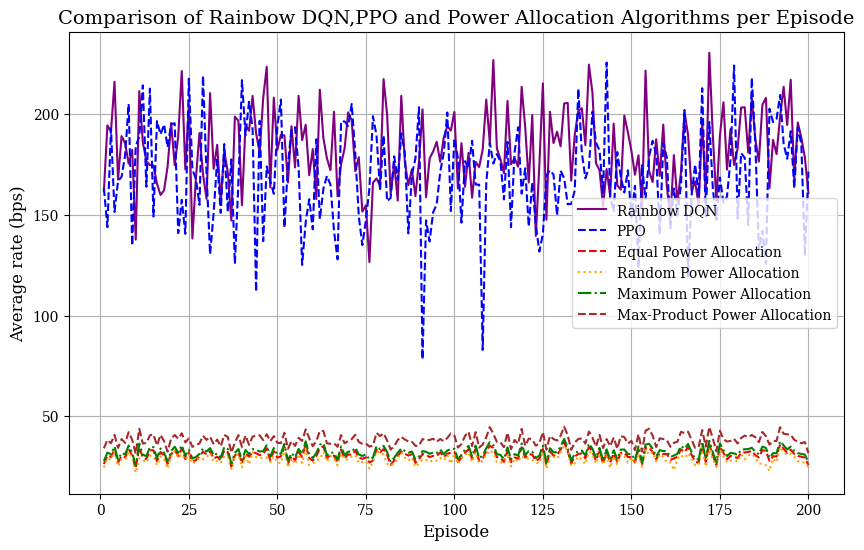

In [ ]:
# Plot the results
episodes = 200
plt.figure(figsize=(10, 6))
plt.plot(range(1, episodes + 1), scores_rainbow, label='Rainbow DQN', color='purple', linestyle='-')
plt.plot(range(1, episodes + 1), scores_ppo, label='PPO', color='blue', linestyle='--')
plt.plot(range(1, episodes + 1), equal_rates, label='Equal Power Allocation', color='red', linestyle='--')
plt.plot(range(1, episodes + 1), random_rates, label='Random Power Allocation', color='orange', linestyle=':')
plt.plot(range(1, episodes + 1), maximum_rates, label='Maximum Power Allocation', color='green', linestyle='-.')
plt.plot(range(1, episodes + 1), maxprob_rates, label='Max-Product Power Allocation', color='brown', linestyle='--')


# Customize the plot
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average rate (bps)', fontsize=12)
plt.title('Comparison of Rainbow DQN,PPO and Power Allocation Algorithms per Episode', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)

# Save the plot
plt.savefig('comparison_ppo_rainbow.png', dpi=300)

# Show the plot
plt.show()